In [1]:
from Functions import *

import json 
#import data_preprocess_functions as dp_f
import argparse, configparser
import re
import ast
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from tensorflow.keras.utils import to_categorical

from tensorflow.keras import Model
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [2]:
def plot_training(history):
    fig = plt.figure()
    plt.subplot(2,1,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    #plt.xscale('log')

    plt.subplot(2,1,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    #plt.xscale('log')

    plt.tight_layout()
    #plt.savefig(path+'MVA_training.pdf')
    plt.show()

    return 

def class_weights_f(data,mode):
    
    size_bkg,size_sig=data.query('isSignal==0').shape[0],data.query('isSignal==1').shape[0]
    size=np.array([size_bkg,size_sig])
    sb_mean=np.mean(size)
    w_sb=sb_mean/size
    #print(w_sb)
    
    ren_masses=np.array(list(set(data['unscaledMass'])))

    ncats=len(ren_masses)
    rec_m=np.array([])
    for ren_mass in ren_masses:
        rec_m=np.append(rec_m,(data.query('isSignal==1')['unscaledMass']==ren_mass).sum())

    n_categories=rec_m
    n_mean=np.mean(n_categories)

    w=n_mean/n_categories
    
    μ=np.mean(w)
    σ=np.std(w)
    
    if mode=='reg_balanced':
        w_tilde=np.array([])
        for i in np.arange(ncats):
            if i in np.where(np.abs(n_categories-n_mean)/n_categories<σ)[0]:
                w_tilde=np.append(w_tilde,w[i])
            else:
                w_tilde=np.append(w_tilde,μ)#-σ/2.)

    if mode=='balanced':
        w_tilde=w

    #w_tilde_norm=w_tilde/w_tilde.sum()
    
    l={}
    for i in np.arange(ncats):
        l.update({ren_masses[i]:w_tilde[i]})
    
    #
    #w_sb is the bkg,sig weight list, l is the signal mass-weight list. final weights are 
    #assigned for each event as 
    #signal_event_weight = * w_sb[1] * l
    #bkg_event_weight = w_sb[0]
    #
    
    return w_sb,l,ren_masses

In [3]:
import math

def Deta(eta_1,eta_2):
    return eta_1-eta_2

def Dphi(phi_1,phi_2):
    dphi = phi_1-phi_2
    if np.abs(dphi)>math.pi:
        return dphi/abs(dphi)*(2*math.pi-(dphi/abs(dphi))*dphi)
    else:
        return dphi
Dphi=np.vectorize(Dphi)

def DR(Deta,Dphi):
    return math.sqrt(Deta**2+Dphi**2)
DR=np.vectorize(DR)


def process_v_data(data):

    deta_l=Deta(data['lep1_eta'],data['lep2_eta'])
    dphi_l=Dphi(data['lep1_phi'],data['lep2_phi'])
    log_dr_l=np.log(DR(deta_l,dphi_l))

    deta_jl=Deta(np.mean([data['lep1_eta'],data['lep2_eta']],axis=0),data['fatjet_eta'])
    dphi_jl=Dphi(np.mean([data['lep1_phi'],data['lep2_phi']],axis=0),data['fatjet_phi'])
    log_dr_jl=np.log(DR(deta_jl,dphi_jl))

    data_df=pd.DataFrame({'deta_leptons': deta_l,'dphi_leptons': dphi_l,'log_dr_leptons': log_dr_l, 'deta_lepjet': deta_jl,'dphi_lepjet': dphi_jl, 'log_dr_lepjet': log_dr_jl})
    data_new=pd.concat([data,data_df],axis=1)
    
    variables=['lep1_m', 'lep1_logpt', 'deta_leptons','dphi_leptons', 'log_dr_leptons',
               'deta_lepjet','dphi_lepjet', 'lep2_m', 'lep2_logpt','log_dr_lepjet','fatjet_m',
               'fatjet_logpt','fatjet_D2', 'Zcand_m', 'Zcand_logpt', 'mass','isSignal']
    return data_new[variables]

In [4]:
analysis='merged'
channel='VBF'
PreselectionCuts=''
samples=['Zjets','Wjets','stop','Diboson','ttbar','Radion','VBFRSG','RSG','VBFRadion','VBFHVTWZ']

### Reading from config file
config = configparser.ConfigParser()
config.read('Configuration_UFO_PFLOW_r33-22.ini')
inputFiles = ast.literal_eval(config.get('config', 'inputFiles'))
#dataType = ast.literal_eval(config.get('config', 'dataType'))
rootBranchSubSample = ast.literal_eval(config.get('config', 'rootBranchSubSample'))
dfPath = config.get('config', 'dfPath')

#list of files under dfPath
files=os.listdir(dfPath)
#InputFeaturesResolved for 'resolved' analysis --> make it dyn
if analysis == 'merged':
    dataVariables = ast.literal_eval(config.get('config', 'InputFeaturesMerged'))
elif analysis == 'resolved':
    dataVariables = ast.literal_eval(config.get('config', 'InputFeaturesResolved'))

#DSID must not be included in the configfile! #
#It's important the order here ! 
dataVariables.append('isSignal')
dataVariables.append('origin')
dfPath = config.get('config', 'dfPath')

In [5]:
dataVariables,len(dataVariables),samples

(['lep1_m',
  'lep1_pt',
  'lep1_eta',
  'lep1_phi',
  'lep2_m',
  'lep2_pt',
  'lep2_eta',
  'lep2_phi',
  'fatjet_m',
  'fatjet_pt',
  'fatjet_eta',
  'fatjet_phi',
  'fatjet_D2',
  'Zcand_m',
  'Zcand_pt',
  'mass',
  'isSignal',
  'origin'],
 18,
 ['Zjets',
  'Wjets',
  'stop',
  'Diboson',
  'ttbar',
  'Radion',
  'VBFRSG',
  'RSG',
  'VBFRadion',
  'VBFHVTWZ'])

In [6]:
data_train_rescaled=pd.read_pickle('/nfs/kloe/einstein4/HDBS/NNoutput/r33-22/UFO_PFLOW/merged/VBF/Radion/all_fullStat/data_train_r33-22_UFO_PFLOW_merged_VBF_none_Radion_all_0.8t.pkl')
data_test_rescaled=pd.read_pickle('/nfs/kloe/einstein4/HDBS/NNoutput/r33-22/UFO_PFLOW/merged/VBF/Radion/all_fullStat/data_test_r33-22_UFO_PFLOW_merged_VBF_none_Radion_all_0.8t.pkl')

with open('/nfs/kloe/einstein4/HDBS/NNoutput/r33-22/UFO_PFLOW/merged/VBF/Radion/all_fullStat/variables.json', 'r') as f:
    scale_dict = json.load(f)

In [7]:
def process_data(data_rescaled,scale_dict,mod,scaler_input):
    data=pd.DataFrame()
    for var in data_rescaled.columns:
        for j in np.arange(len(scale_dict['inputs'])):
            if scale_dict['inputs'][j]['name']==var:
                print(var)
                offset=scale_dict['inputs'][j]['offset']
                scale=scale_dict['inputs'][j]['scale']
                data=pd.concat([data,pd.DataFrame({str(var) : data_rescaled[var].apply(lambda x: (x*scale)+offset)})],axis=1)

    data=pd.concat([data,data_rescaled[['X_boosted_m', 'weight', 'isSignal', 'origin', 'train_weight', 'unscaledMass']]],axis=1)

    data_tmp=data.copy()
    data_tmp['lep1_pt']=data_tmp['lep1_pt'].apply(lambda x: np.log(x))
    data_tmp['lep2_pt']=data_tmp['lep2_pt'].apply(lambda x: np.log(x))
    data_tmp['fatjet_pt']=data_tmp['fatjet_pt'].apply(lambda x: np.log(x))
    data_tmp['Zcand_pt']=data_tmp['Zcand_pt'].apply(lambda x: np.log(x))
    data_tmp=data_tmp.rename(columns={'lep1_pt':'lep1_logpt','lep2_pt':'lep2_logpt','fatjet_pt':'fatjet_logpt','Zcand_pt':'Zcand_logpt'})

    bs_weights,s_weights,masses=class_weights_f(data_tmp,'balanced')
    
    data_newvars=process_v_data(data_tmp)

    weights=np.ones(data_newvars.shape[0])*bs_weights[0]
    for mass in masses:
        weights[np.intersect1d(np.where(data_newvars['isSignal']==1)[0],np.where(data_newvars['mass']==mass)[0])]=bs_weights[1]*s_weights[mass]


#    plt.hist(data_train_newvars['log_dr_leptons'],bins=100,histtype='step')
#    plt.hist(data_train_newvars['log_dr_lepjet'],bins=100,histtype='step')
#    plt.show()

#    plt.hist(data_train_newvars['deta_leptons'],bins=100,histtype='step')
#    plt.hist(data_train_newvars['deta_lepjet'],bins=100,histtype='step')
#    plt.show()

#    plt.hist(data_train_newvars['dphi_leptons'],bins=100,histtype='step')
#    plt.hist(data_train_newvars['dphi_lepjet'],bins=100,histtype='step')
#    plt.show()


    train_vars=['lep1_m', 'lep1_logpt', 'deta_leptons', 'log_dr_leptons',
                   'deta_lepjet', 'lep2_m', 'lep2_logpt','log_dr_lepjet','fatjet_m',
                   'fatjet_logpt','fatjet_D2', 'Zcand_m', 'Zcand_logpt', 'mass']#X_boosted_m

    X_train=np.array(data_newvars[train_vars])
    y=np.array(data_newvars['isSignal'])



    if mod=='train':
        scaler = StandardScaler()
    if mod=='test':
        scaler=scaler_input
        weights=data_rescaled['train_weight']
        
    X_train_scaled = scaler.fit_transform(X_train)

    X_train_scaled,y,weights=shuffle(X_train_scaled,y,weights)

    return X_train_scaled,y,weights,scaler

In [8]:
X_train,y_train,train_weights,train_scaler=process_data(data_train_rescaled,scale_dict,'train',None)

lep1_m
lep1_pt
lep1_eta
lep1_phi
lep2_m
lep2_pt
lep2_eta
lep2_phi
fatjet_m
fatjet_pt
fatjet_eta
fatjet_phi
fatjet_D2
Zcand_m
Zcand_pt
mass


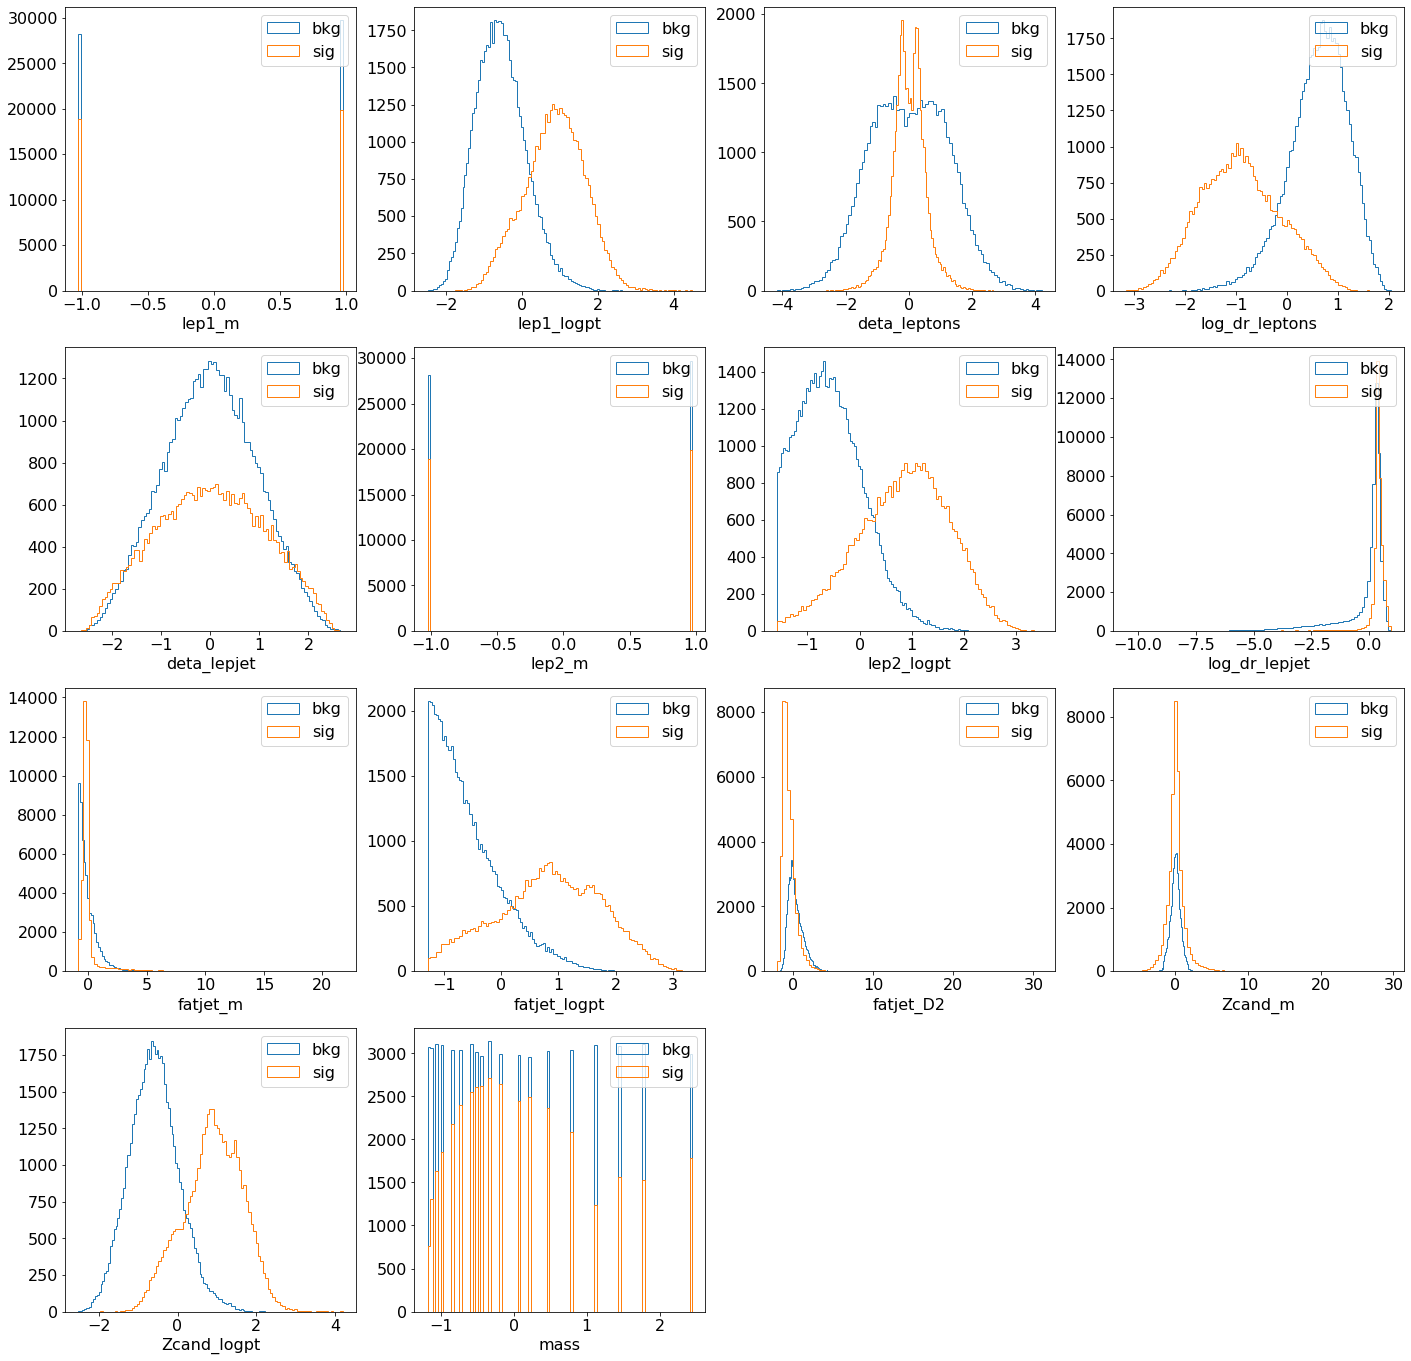

In [9]:
train_vars=['lep1_m', 'lep1_logpt', 'deta_leptons', 'log_dr_leptons',
                   'deta_lepjet', 'lep2_m', 'lep2_logpt','log_dr_lepjet','fatjet_m',
                   'fatjet_logpt','fatjet_D2', 'Zcand_m', 'Zcand_logpt', 'mass']
fig=plt.figure(figsize=(24,24))
gs = gridspec.GridSpec(nrows=4, ncols=4, width_ratios=[1,1,1,1],figure=fig)
    
for var in np.arange(X_train.shape[1]):
    ax=fig.add_subplot(gs[var])
    ax.hist(X_train[np.where(y_train==0)[0],var],bins=100,histtype='step',label='bkg')
    ax.hist(X_train[np.where(y_train==1)[0],var],bins=100,histtype='step',label='sig')
    ax.set_xlabel(train_vars[var])
    ax.legend()
    
plt.show()


In [88]:
from numpy import linalg as la

In [11]:
X_train.shape

(96671, 14)

In [64]:
C=np.cov(X_train[:1000,:])
C.shape

(1000, 1000)

In [76]:
(C==C.T).all()

True

In [89]:
λ,v=la.eigh(C)

In [80]:
C_rand=np.cov(np.random.rand(1000,1000))

In [96]:
λ_r,v_r=la.eigh(C_rand)

In [97]:
eigvals_r=np.absolute(λ_r)
eigvals_r.sort()

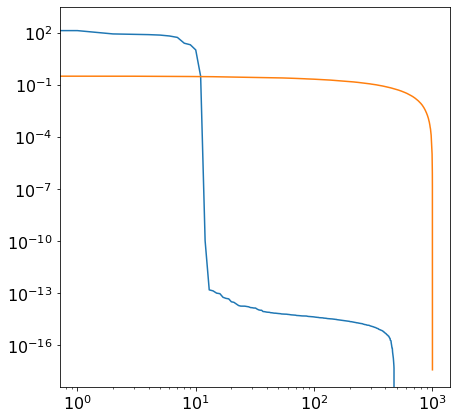

In [98]:
plt.plot(np.arange(1000),λ[::-1])
plt.plot(np.arange(1000),eigvals_r[::-1])
plt.xscale('log')
plt.yscale('log')
plt.show()

In [102]:
v=v[::-1]
λ=λ[::-1]

In [119]:
fract_eigenval=np.array([])
for n in np.arange(1,len(λ)):
#n=12
    fract_eigenval=np.append(fract_eigenval,λ[:n].sum()/np.absolute(λ).sum())
    

In [120]:
fract_eigenval>0.99967213

array([0.3417625 , 0.48155277, 0.57153639, 0.65711988, 0.73911929,
       0.81624659, 0.88471082, 0.94131228, 0.96752116, 0.98892918,
       0.99967213, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

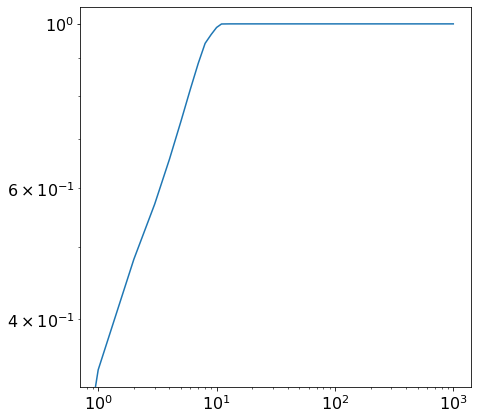

In [114]:
plt.plot(np.arange(1000),fract_eigenval)
#plt.plot(np.arange(1000),eigvals_r[::-1])
plt.xscale('log')
plt.yscale('log')
plt.show()

In [11]:
#lep energy

In [18]:
def F_MVA(in_size,out_size):
    n_c=32
    opt = tf.keras.optimizers.Adam(learning_rate=0.01)#was 0.005
    
    input_layer = Input(shape=(in_size,))
    L_1=Dense(n_c, activation=tf.nn.relu)(input_layer)
    L_2=Dense(n_c, activation=tf.nn.relu)(L_1)
    #L_3=Dense(n_c, activation=tf.nn.relu)(L_2)
    #L_4=Dense(4*n_c, activation=tf.nn.relu)(L_3)
    #L_5=Dense(4*n_c, activation=tf.nn.relu)(L_4)
    #L_6=Dense(2*n_c, activation=tf.nn.sigmoid, kernel_regularizer=tf.keras.regularizers.l2(l=0.1))(L_2)
#    L_7=Dense(n_c, activation=tf.nn.relu)(L_6)
#    L_8=Dense(n_c, activation=tf.nn.relu)(L_7)
    output_layer=Dense(out_size, activation='softmax', name='preds')(L_2)

    NN = Model(inputs=input_layer, outputs=output_layer)
    NN.compile( optimizer=opt, loss='categorical_crossentropy', metrics = ['accuracy'] )
    
    return NN

In [19]:
NN = F_MVA(X_train.shape[1],2)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights = True)

In [20]:
history_w=NN.fit(X_train, to_categorical(y_train), 
               #batch_size=256,#16384,#8192,#1024, 
               epochs=100,
               verbose=1, 
               validation_split=0.2,
               callbacks=[callback], 
               sample_weight=train_weights
              )

Epoch 1/100
2417/2417 [==============================] - ETA: 20:25 - loss: 0.5195 - accuracy: 0.875 - ETA: 3s - loss: 0.3628 - accuracy: 0.8628  - ETA: 3s - loss: 0.3406 - accuracy: 0.86 - ETA: 3s - loss: 0.3291 - accuracy: 0.87 - ETA: 3s - loss: 0.3182 - accuracy: 0.87 - ETA: 3s - loss: 0.3109 - accuracy: 0.88 - ETA: 3s - loss: 0.3033 - accuracy: 0.88 - ETA: 2s - loss: 0.2973 - accuracy: 0.88 - ETA: 2s - loss: 0.2932 - accuracy: 0.88 - ETA: 2s - loss: 0.2892 - accuracy: 0.88 - ETA: 2s - loss: 0.2859 - accuracy: 0.88 - ETA: 2s - loss: 0.2826 - accuracy: 0.89 - ETA: 2s - loss: 0.2797 - accuracy: 0.89 - ETA: 2s - loss: 0.2771 - accuracy: 0.89 - ETA: 2s - loss: 0.2746 - accuracy: 0.89 - ETA: 2s - loss: 0.2723 - accuracy: 0.89 - ETA: 2s - loss: 0.2703 - accuracy: 0.89 - ETA: 2s - loss: 0.2685 - accuracy: 0.89 - ETA: 2s - loss: 0.2668 - accuracy: 0.89 - ETA: 2s - loss: 0.2652 - accuracy: 0.89 - ETA: 2s - loss: 0.2636 - accuracy: 0.89 - ETA: 2s - loss: 0.2621 - accuracy: 0.89 - ETA: 2s - lo

2417/2417 [==============================] - ETA: 6s - loss: 0.1928 - accuracy: 0.93 - ETA: 2s - loss: 0.1607 - accuracy: 0.92 - ETA: 3s - loss: 0.1517 - accuracy: 0.93 - ETA: 3s - loss: 0.1484 - accuracy: 0.93 - ETA: 3s - loss: 0.1470 - accuracy: 0.94 - ETA: 3s - loss: 0.1458 - accuracy: 0.94 - ETA: 2s - loss: 0.1450 - accuracy: 0.94 - ETA: 2s - loss: 0.1451 - accuracy: 0.94 - ETA: 2s - loss: 0.1449 - accuracy: 0.94 - ETA: 2s - loss: 0.1450 - accuracy: 0.94 - ETA: 2s - loss: 0.1451 - accuracy: 0.94 - ETA: 2s - loss: 0.1451 - accuracy: 0.94 - ETA: 2s - loss: 0.1450 - accuracy: 0.94 - ETA: 2s - loss: 0.1449 - accuracy: 0.94 - ETA: 2s - loss: 0.1446 - accuracy: 0.94 - ETA: 2s - loss: 0.1443 - accuracy: 0.94 - ETA: 2s - loss: 0.1440 - accuracy: 0.94 - ETA: 2s - loss: 0.1438 - accuracy: 0.94 - ETA: 2s - loss: 0.1437 - accuracy: 0.94 - ETA: 2s - loss: 0.1435 - accuracy: 0.94 - ETA: 2s - loss: 0.1434 - accuracy: 0.94 - ETA: 2s - loss: 0.1432 - accuracy: 0.94 - ETA: 2s - loss: 0.1431 - accura

In [21]:
callback.stopped_epoch

7

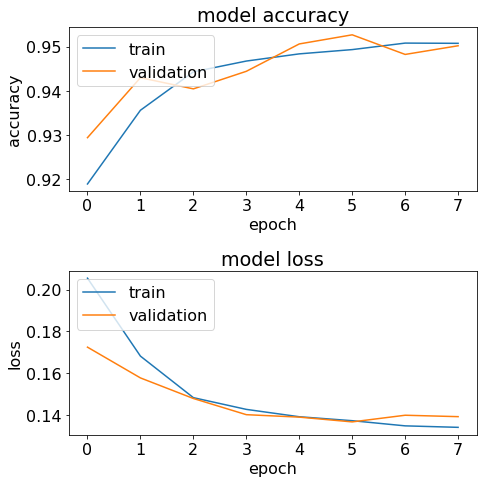

In [22]:
#with weights
plot_training(history_w)

In [23]:
X_test,y_test,test_weights,test_scaler=process_data(data_test_rescaled,scale_dict,'test',train_scaler)

lep1_m
lep1_pt
lep1_eta
lep1_phi
lep2_m
lep2_pt
lep2_eta
lep2_phi
fatjet_m
fatjet_pt
fatjet_eta
fatjet_phi
fatjet_D2
Zcand_m
Zcand_pt
mass


In [24]:
NN.evaluate(X_train,to_categorical(y_train),sample_weight=train_weights)

3021/3021 [==============================] - ETA: 1:18 - loss: 0.1289 - accuracy: 0.93 - ETA: 2s - loss: 0.1357 - accuracy: 0.9581 - ETA: 2s - loss: 0.1260 - accuracy: 0.95 - ETA: 2s - loss: 0.1266 - accuracy: 0.95 - ETA: 2s - loss: 0.1349 - accuracy: 0.95 - ETA: 2s - loss: 0.1336 - accuracy: 0.95 - ETA: 2s - loss: 0.1309 - accuracy: 0.95 - ETA: 2s - loss: 0.1317 - accuracy: 0.95 - ETA: 2s - loss: 0.1310 - accuracy: 0.95 - ETA: 2s - loss: 0.1300 - accuracy: 0.95 - ETA: 2s - loss: 0.1286 - accuracy: 0.95 - ETA: 2s - loss: 0.1272 - accuracy: 0.95 - ETA: 2s - loss: 0.1269 - accuracy: 0.95 - ETA: 2s - loss: 0.1261 - accuracy: 0.95 - ETA: 2s - loss: 0.1253 - accuracy: 0.95 - ETA: 2s - loss: 0.1272 - accuracy: 0.95 - ETA: 2s - loss: 0.1276 - accuracy: 0.95 - ETA: 2s - loss: 0.1284 - accuracy: 0.95 - ETA: 2s - loss: 0.1280 - accuracy: 0.95 - ETA: 2s - loss: 0.1281 - accuracy: 0.95 - ETA: 2s - loss: 0.1281 - accuracy: 0.95 - ETA: 2s - loss: 0.1272 - accuracy: 0.95 - ETA: 2s - loss: 0.1286 - ac

[0.12937262654304504, 0.9532331228256226]

In [25]:
NN.evaluate(X_test,to_categorical(y_test),sample_weight=test_weights)

756/756 [==============================] - ETA: 2:04 - loss: 0.0284 - accuracy: 0.96 - ETA: 1s - loss: 0.0841 - accuracy: 0.9542 - ETA: 1s - loss: 0.1044 - accuracy: 0.95 - ETA: 1s - loss: 0.1088 - accuracy: 0.95 - ETA: 1s - loss: 0.1040 - accuracy: 0.95 - ETA: 1s - loss: 0.1007 - accuracy: 0.95 - ETA: 1s - loss: 0.1026 - accuracy: 0.95 - ETA: 1s - loss: 0.0963 - accuracy: 0.95 - ETA: 1s - loss: 0.0958 - accuracy: 0.95 - ETA: 1s - loss: 0.0924 - accuracy: 0.95 - ETA: 1s - loss: 0.0964 - accuracy: 0.95 - ETA: 0s - loss: 0.0978 - accuracy: 0.95 - ETA: 0s - loss: 0.0954 - accuracy: 0.95 - ETA: 0s - loss: 0.0971 - accuracy: 0.95 - ETA: 0s - loss: 0.0960 - accuracy: 0.95 - ETA: 0s - loss: 0.0959 - accuracy: 0.95 - ETA: 0s - loss: 0.0946 - accuracy: 0.95 - ETA: 0s - loss: 0.0961 - accuracy: 0.95 - ETA: 0s - loss: 0.0951 - accuracy: 0.95 - ETA: 0s - loss: 0.0968 - accuracy: 0.95 - ETA: 0s - loss: 0.0978 - accuracy: 0.95 - ETA: 0s - loss: 0.1004 - accuracy: 0.95 - ETA: 0s - loss: 0.1014 - accu

[0.0997193306684494, 0.9534094929695129]

In [26]:
X_test.shape,test_weights.shape

((24168, 14), (24168,))

In [27]:
#resolved --> similar analysis
#X_boosted_m as a single variable
#-1 layer
#MC weights
#sensitvity

In [28]:
PNN_pred_bkg=NN.predict(X_test[np.where(y_test==0)])
PNN_pred_sig=NN.predict(X_test[np.where(y_test==1)])

In [29]:
X_boosted_m_bkg=np.array(data_test_rescaled.query('isSignal==0')['X_boosted_m'])
X_boosted_m_sig=np.array(data_test_rescaled.query('isSignal==1')['X_boosted_m'])

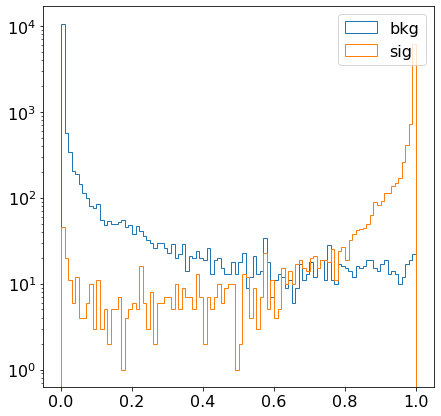

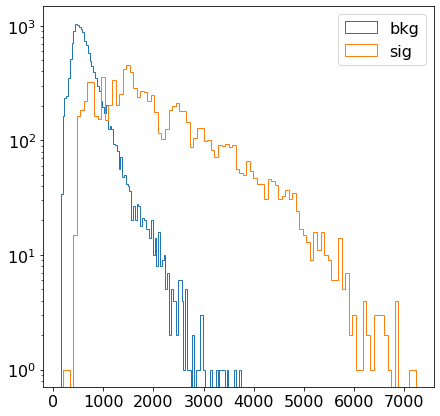

In [30]:
nbins=100
plt.hist(PNN_pred_bkg[:,1],bins=nbins,histtype='step',label='bkg')
plt.hist(PNN_pred_sig[:,1],bins=nbins,histtype='step',label='sig')
plt.yscale('log')
plt.legend()
plt.show()

plt.hist(X_boosted_m_bkg,bins=nbins,histtype='step',label='bkg')
plt.hist(X_boosted_m_sig,bins=nbins,histtype='step',label='sig')
plt.yscale('log')
plt.legend()
plt.show()


In [31]:
#calculate probability
#poisson.pmf(k=5, mu=3)

def poisson_pdf(n,μ):
    if μ>0:
        return poisson.pmf(k=n,mu=μ)
    else: 
        return 0

poisson_pdf=np.vectorize(poisson_pdf)


def compute_sig(p):
    p=min(p,0.5)
    #print('p:',p_sum)
    Z=stats.norm.ppf(1-p)
    #print('Z value:',Z)
    
    return Z


def significance_1bin(bkg_yeld,bkg_weights,sig_yeld,sig_weights,ϵ):
    cut=1e-24
    
    yeld_bkg,_=np.histogram(bkg_yeld,bins=1,weights=bkg_weights)
    yeld_sig,_=np.histogram(sig_yeld,bins=1,weights=sig_weights)
    yeld_bkg,yeld_sig=int_v(yeld_bkg),int_v(yeld_sig)
    
    probs=poisson_pdf(yeld_bkg+int_v(ϵ*yeld_sig),yeld_bkg)
    p=np.prod(probs)

    n,b=rescaling_distr(yeld_bkg,yeld_sig,ϵ)
    N_max=int(n*100)

    p_sum=0
    for k in np.arange(n,N_max):
        p=poisson_pdf(k,b)
        if p<cut:
            break
        else:
            p_sum=p_sum+p

    Z=compute_sig(p_sum)
#    print(Z,p_sum)
    return Z


def compute_p(ntot,nbkg):
    #ϵ=1e-10
#    mean_point=0.5*(bkg_yeld.min()+sig_yeld.max())

    #print('bkg only:',yeld_bkg)
    #print('sig+bkg:',yeld_bkg+int_v(ϵ*yeld_sig))
    probs=poisson_pdf(ntot,nbkg)

    p=np.prod(probs)
    return p

def significance_2bins(bkg_yeld,bkg_weights,sig_yeld,sig_weights,ϵ):
    #ϵ=1e-3
    Nsteps=1000
    #print('epsilon rescaling of signal:',ϵ)
    
    Z_tmp=0
    Z=0
    
    a=bkg_yeld.min()
    b=sig_yeld.max()
    x=0
    for i in np.arange(Nsteps):
        ampl=b-a
        x_tmp=a+(b-a)*np.random.rand(1)
        #print(a,b,x_tmp,Z_tmp)
        yeld_bkg,yeld_sig=derive_distr(bkg_yeld,bkg_weights,sig_yeld,sig_weights,x_tmp)
        
        ntot,nbkg=rescaling_distr(yeld_bkg,yeld_sig,1e-10)
        p=compute_p(ntot,nbkg)     #bkg only
        #print(p)
        
        ntot,nbkg=rescaling_distr(yeld_bkg,yeld_sig,ϵ)
        p_sum=compute_p(ntot,nbkg) #sig+bkg
        #print(p_sum)
        
        p_sum=p_sum*(0.5/p)        #rescale
        Z_tmp=compute_sig(p_sum)
        if Z_tmp>Z:
            Z=Z_tmp
            s=(x_tmp-x)/np.abs(x_tmp-x)
            if s>0:
                a=max(x_tmp-1e-3*ampl,bkg_yeld.min())
            if s<0:
                b=min(x_tmp+1e-3*ampl,sig_yeld.max())
            
            x=x_tmp
            
    print(Z,x)
    
    return Z,x

def compute_psum_N(N,nbkg):
    b1=nbkg[0]
    b2=nbkg[1]
    
    p=0
    for n1 in np.arange(0,N+1):
        n2=N-n1
        prob=poisson_pdf([n1,n2],nbkg).prod() #sig+bkg
        p=p+prob

    return p

def compute_psum_N_partial(N,nbkg):
    b1=nbkg[0]
    b2=nbkg[1]
    
    Nbsteps=100
    p=0
    x10=max(b1-Nbsteps,0)
    x11=min(b1+Nbsteps,N)
    x20=max(N-b2-Nbsteps,0)
    x21=min(N-b2+Nbsteps,N)
    if x10<=x21:
        n_range=np.arange(x20,x11)
    if x20<=x11:
        n_range=np.arange(x10,x21)
    else:
        n_range=np.append(np.arange(x10,x11),np.arange(x20,x21))
        
    for n1 in n_range:
        n2=N-n1
        prob=poisson_pdf([n1,n2],nbkg).prod() #sig+bkg
        p=p+prob

    return p

                
def compute_psum(ntot,nbkg,Nsteps):
    
    #nbkg is fixed
    #ntot varies
    b1=nbkg[0]
    b2=nbkg[1]
    
    Nobs=ntot.sum()
    #print(b1,ntot-b2)
    p_sum=0
    #Nsteps=400#500
    for N in np.arange(Nobs,Nobs+Nsteps):
        p_sum=p_sum+compute_psum_N_partial(N,nbkg)
        if N%100==0:
            print(N,p_sum,' --> N,p_sum')
    return p_sum


def compute_z(bkg_yeld,bkg_weights,sig_yeld,sig_weights,x,ϵ,Nsteps):
    yeld_bkg,yeld_sig=derive_distr(bkg_yeld,bkg_weights,sig_yeld,sig_weights,x)
    ntot,nbkg=rescaling_distr(yeld_bkg,yeld_sig,ϵ)
    #print(ntot,nbkg)
    p_sum=compute_psum(ntot,nbkg,Nsteps)
    Z=compute_sig(p_sum)
    return Z,p_sum


def significance_2bins_v3(bkg_yeld,bkg_weights,sig_yeld,sig_weights,ϵ):
    Nsteps=100
    Nbsteps=5
    
    a=bkg_yeld.min()
    b=sig_yeld.max()
    ampl_0=b-a

    x=a+ampl_0*1e-2*np.random.rand(1)
    #print('interval:',a,b,'x:',x)
    Z,p_sum=compute_z(bkg_yeld,bkg_weights,sig_yeld,sig_weights,x,ϵ,Nbsteps)
    #print('first Z:',Z)
    
    for i in np.arange(Nsteps):
        ampl=b-a
        if ampl<ampl_0/1e2:
            break
        x_tmp=a+ampl*np.random.rand(1)
        #print('interval:',a,b,'x:',x_tmp)
        Z_tmp,p_sum=compute_z(bkg_yeld,bkg_weights,sig_yeld,sig_weights,x_tmp,ϵ,Nbsteps)
        #print('here:', x_tmp,p_sum,Z_tmp)
        
        if Z_tmp>Z and p_sum>0:

            Z=Z_tmp
            s=(x_tmp-x)/np.abs(x_tmp-x)
            if s>0:
                a=max(x_tmp-1e-3*ampl,bkg_yeld.min())
            if s<0:
                b=min(x_tmp+1e-3*ampl,sig_yeld.max())

            x=x_tmp
            print(i,'new x:',x)

    print('x:',x)
    Z,p_sum=compute_z(bkg_yeld,sig_yeld,x,ϵ,500)
    print('Z:',Z)

    return Z,x



In [32]:
from scipy import stats
from scipy.stats import poisson


def derive_distr(bkg_yeld,bkg_weights,sig_yeld,sig_weights,a,b,x_opt):
    boosted_m_bins_range=np.array([a,x_opt,b])

    yeld_bkg,_=np.histogram(bkg_yeld,bins=boosted_m_bins_range,weights=bkg_weights)
    yeld_sig,_=np.histogram(sig_yeld,bins=boosted_m_bins_range,weights=sig_weights)
    
    return yeld_bkg,yeld_sig

def rescaling_distr(yeld_bkg,yeld_sig,ϵ):
    return int_v(yeld_bkg+int_v(ϵ*yeld_sig)),int_v(yeld_bkg)


def int_v(x):
    return int(x)
int_v=np.vectorize(int_v)

In [33]:
def compute_Z0(bkg_yeld,bkg_weights,sig_yeld,sig_weights,a,b,x,ϵ):
    b_inf=1
    if x==-1:
        yeld_bkg,_=np.histogram(bkg_yeld,bins=1,weights=bkg_weights)
        yeld_sig,_=np.histogram(sig_yeld,bins=1,weights=sig_weights)
    else:
        yeld_bkg,yeld_sig=derive_distr(bkg_yeld,bkg_weights,sig_yeld,sig_weights,a,b,x)
        
    n,b=rescaling_distr(yeld_bkg,yeld_sig,ϵ)
    if b.min()>b_inf:
        return np.sqrt((2*(n*np.log(n/b)+b-n)).sum()),b.min()
    else:
        return 0,b.min()

def compute_sigz0(bkg_yeld,bkg_weights,sig_yeld,sig_weights,ϵ,flag):
    b_inf=1
    
    a=min(bkg_yeld.min(),sig_yeld.min())
    b=max(sig_yeld.max(),bkg_yeld.max())
    
    #print(int(a*1e2)+10,int(b*1e2))
    ampl=int(b*1e2)-int(a*1e2)+1
    x_interval=np.arange(int(a*1e2+1),int(b*1e2),ampl*1e-2)*1e-2
    #print(len(x_interval),x_interval.min(),x_interval.max(),x_interval)
    Z0=np.array([])
    bmin=np.array([])
    if flag=='boosted_m':
        x0=x_interval[0]
        x1=x_interval[-1]
    else:
        x0=a
        x1=b
    print(x0,x1)
    for x in x_interval:
        z,b=compute_Z0(bkg_yeld,bkg_weights,sig_yeld,sig_weights,x0,x1,x,ϵ)
        Z0=np.append(Z0,z)
        bmin=np.append(bmin,b)
    
    Z0_max=Z0[np.where(bmin>b_inf)[0]].max()
    x0_max=x_interval[Z0==Z0_max].max()
    print('max z0:',Z0_max)
              
    return Z0_max,x0_max,Z0,bmin,x_interval

In [34]:
bkg_test_weights=np.array(test_weights)[[np.where(y_test==0)[0]]]
sig_test_weights=np.array(test_weights)[[np.where(y_test==1)[0]]]

<ipython-input-34-146244102eb0>:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bkg_test_weights=np.array(test_weights)[[np.where(y_test==0)[0]]]
<ipython-input-34-146244102eb0>:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sig_test_weights=np.array(test_weights)[[np.where(y_test==1)[0]]]


In [37]:
#test mass

In [38]:
masses_list=np.sort(np.array(list(set(data_test_rescaled['unscaledMass']))))
masses_list_norm=np.sort(np.array(list(set(X_test[:,-1]))))
mass_conversion_dict=dict(zip(masses_list,masses_list_norm))

In [39]:
X_boosted_variablem_sig=list()
X_boosted_variablem_sig_weights=list()
for mass in masses_list:
    X_boosted_variablem_sig.append(np.array(data_test_rescaled.query(f'unscaledMass=={mass} and isSignal==1')['X_boosted_m']))
    X_boosted_variablem_sig_weights.append(np.array(data_test_rescaled.query(f'unscaledMass=={mass} and isSignal==1')['train_weight']))
    
    
X_boosted_variablem_bkg=np.array(data_test_rescaled.query('isSignal==0')['X_boosted_m'])
X_boosted_variablem_bkg_weights=np.array(data_test_rescaled.query('isSignal==0')['train_weight'])

500


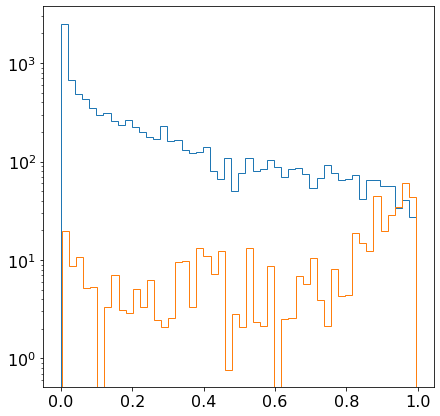

600


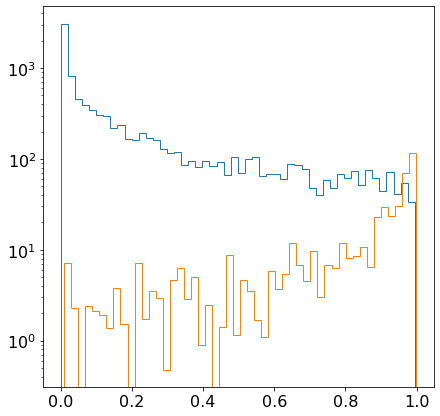

700


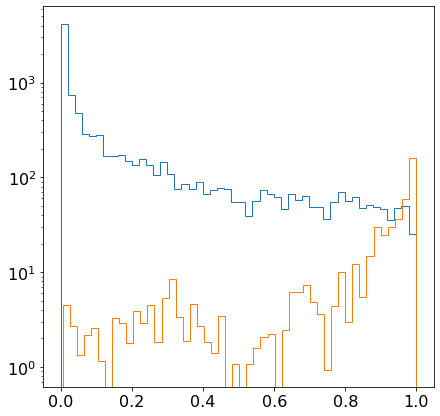

800


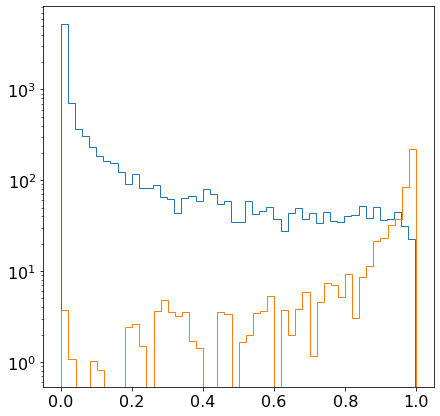

1000


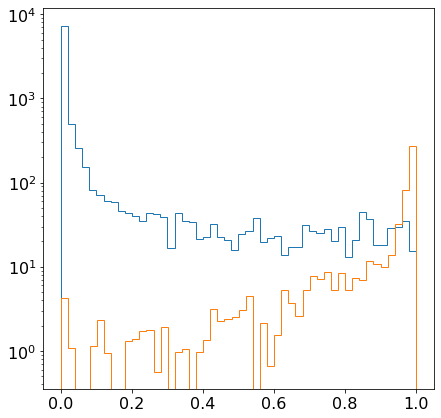

1200


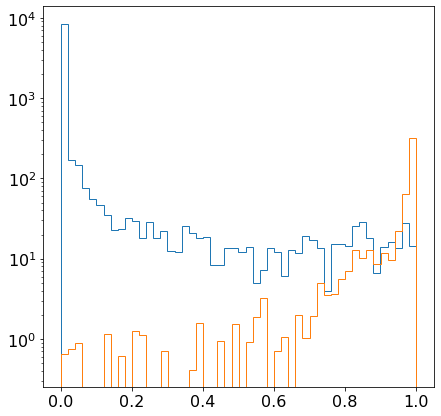

1400


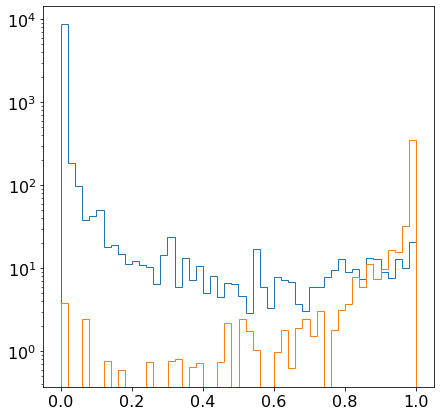

1500


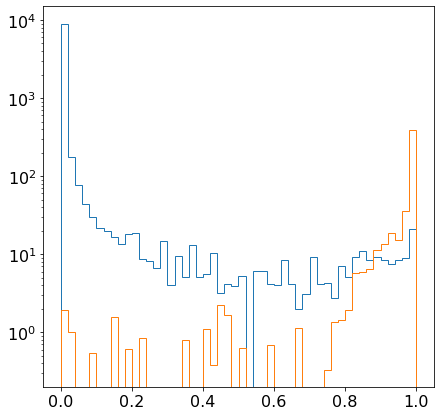

1600


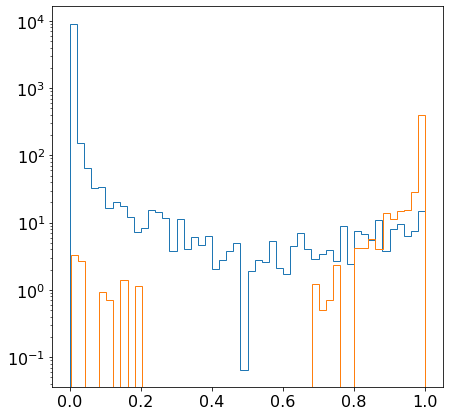

1800


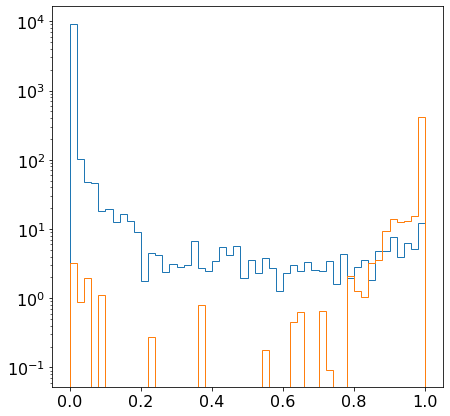

2000


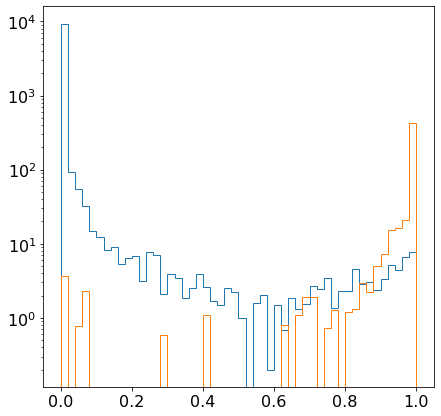

2400


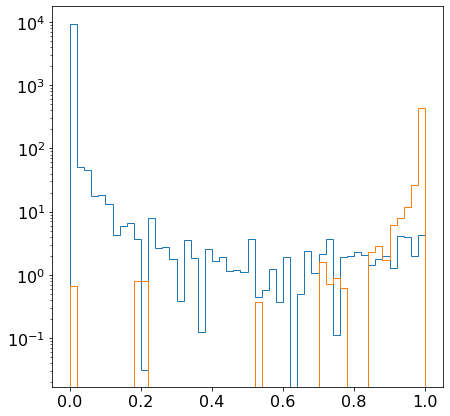

2600


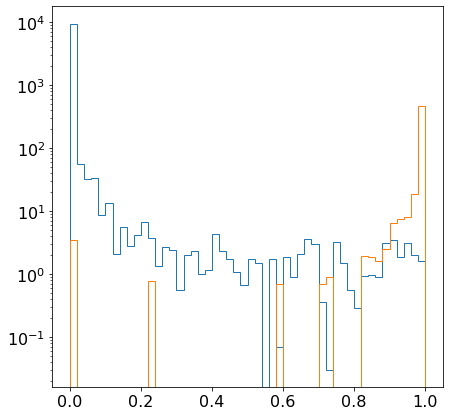

3000


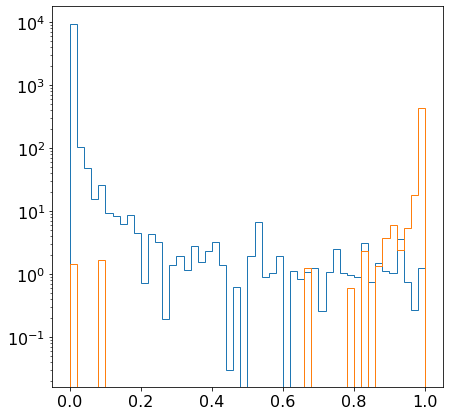

3500


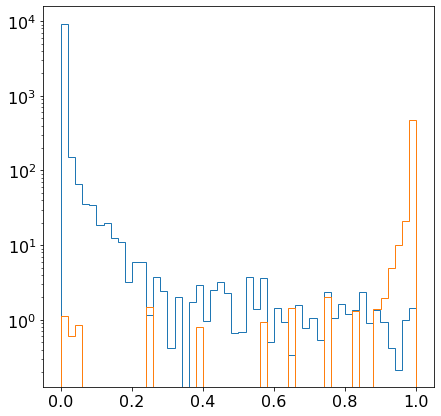

4000


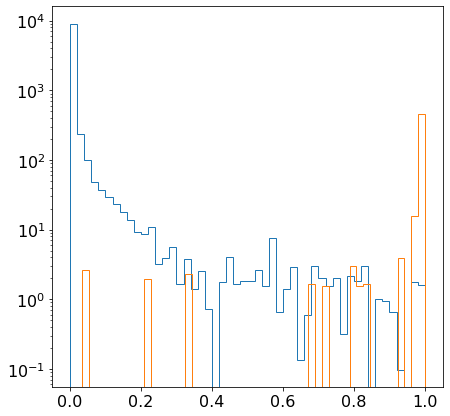

4500


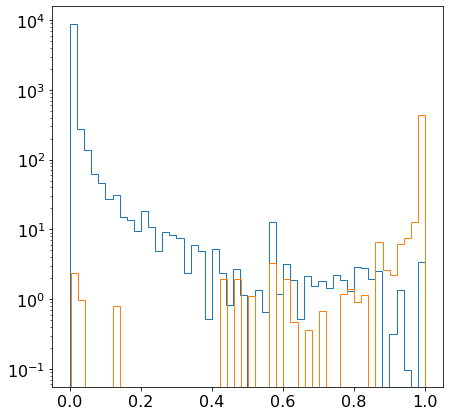

5000


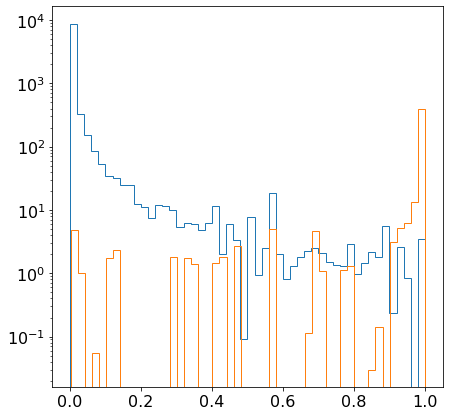

6000


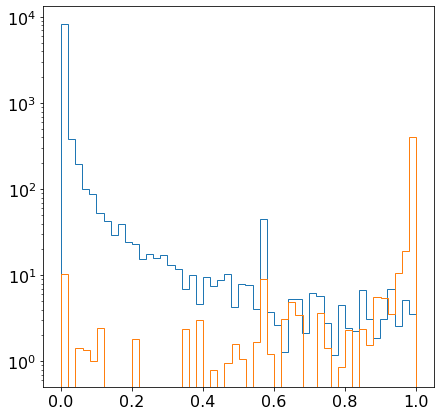

In [40]:
PNN_pred_bkg_testmass=list()
PNN_pred_sig_testmass=list()
bkg_test_weights_testmass=list()
sig_test_weights_testmass=list()
i=0
for mass in masses_list:
    print(mass)
    X_test_bkg_testmass=np.c_[X_test[np.where(y_test==0),:-1][0],mass_conversion_dict[mass]*np.ones(y_test[np.where(y_test==0)].shape[0]).T]
    X_test_sig_testmass=X_test[np.intersect1d(np.where(X_test[:,-1]==masses_list_norm[i])[0],np.where(y_test==1))]
    bkg_test_weights_testmass.append(np.array(test_weights)[np.where(y_test==0)])
    sig_test_weights_testmass.append(np.array(test_weights)[np.intersect1d(np.where(X_test[:,-1]==masses_list_norm[i])[0],np.where(y_test==1))])
    
    PNN_pred_bkg_testmass.append(NN.predict(X_test_bkg_testmass)[:,1])
    PNN_pred_sig_testmass.append(NN.predict(X_test_sig_testmass)[:,1])
    
    #plt.hist(PNN_pred_bkg_testmass[i],bins=50,histtype='step',label='bkg',weights=bkg_test_weights_testmass[i])
    #plt.hist(PNN_pred_sig_testmass[i],bins=50,histtype='step',label='sig',weights=sig_test_weights_testmass[i])
    #plt.yscale('log')
    #plt.show()
    i=i+1

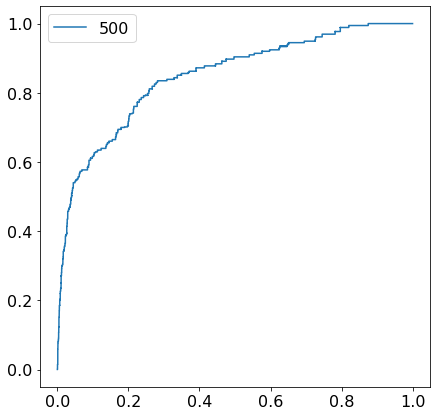

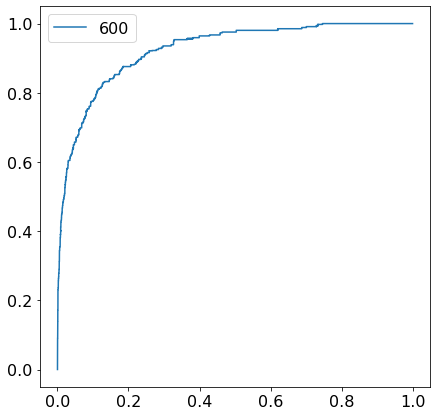

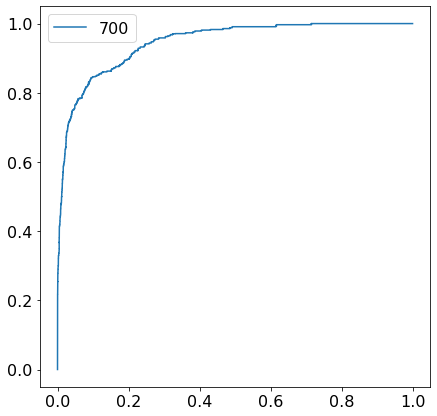

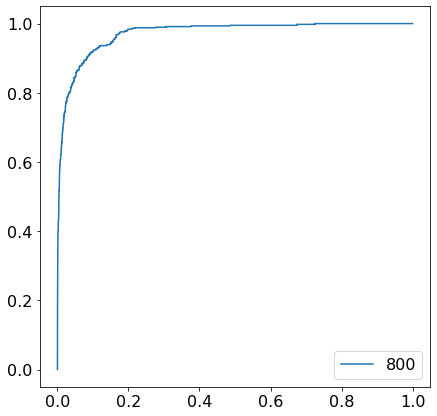

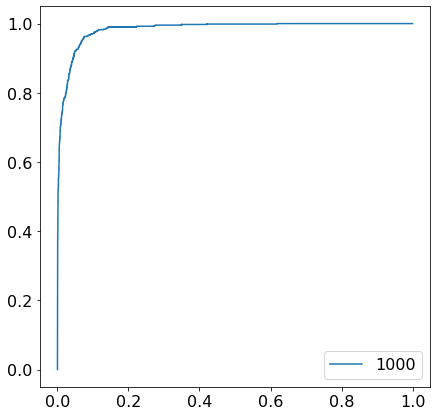

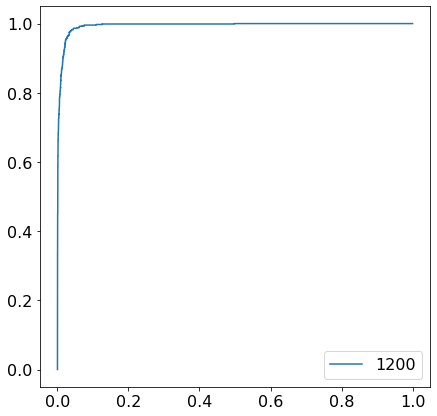

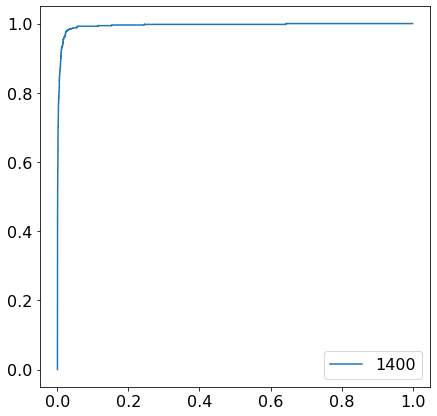

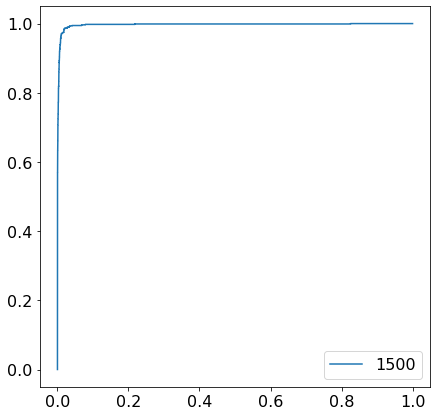

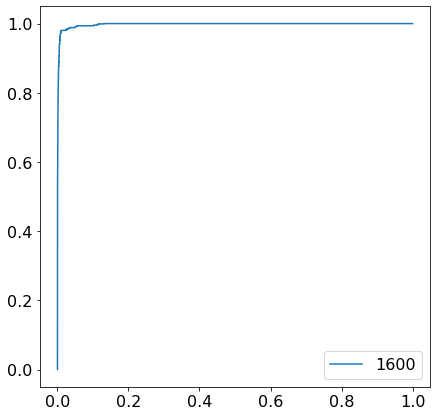

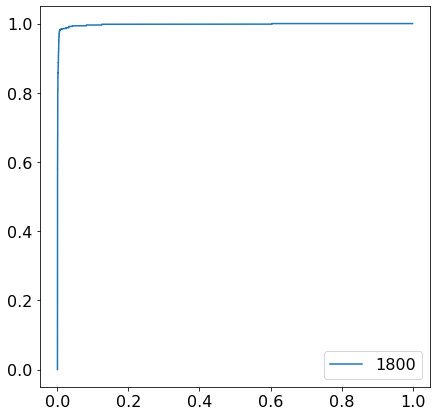

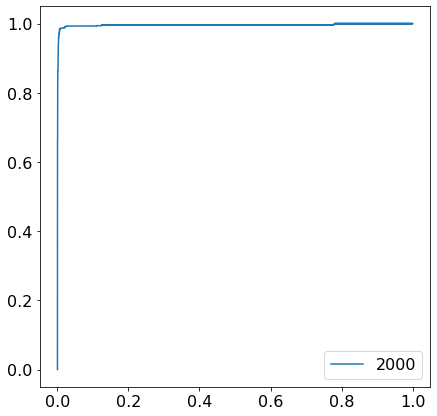

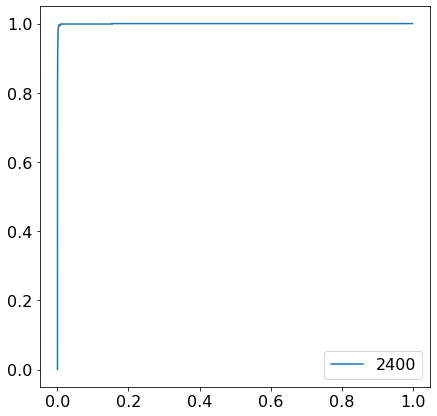

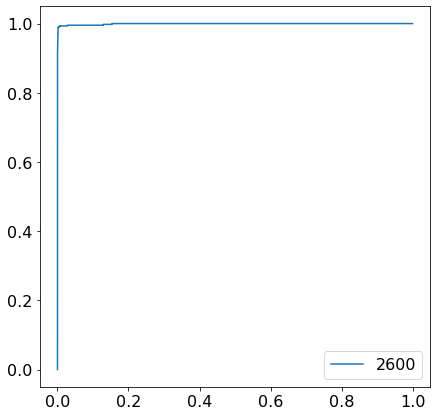

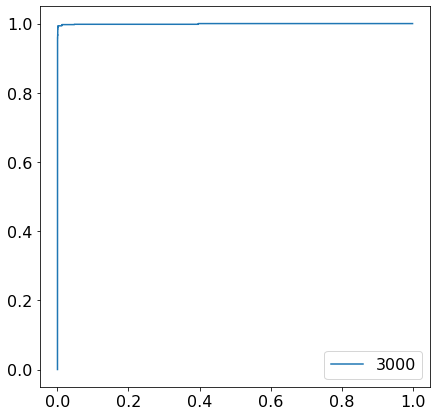

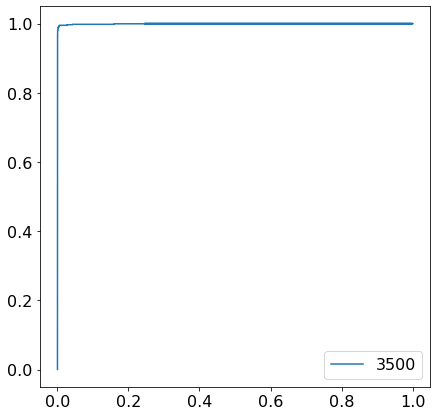

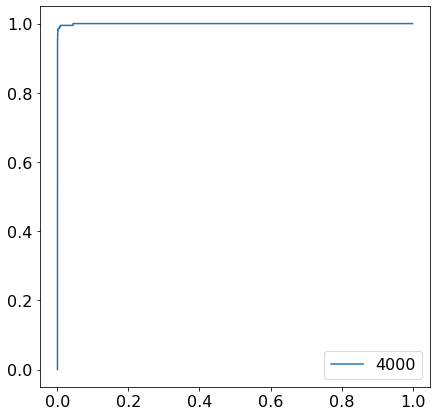

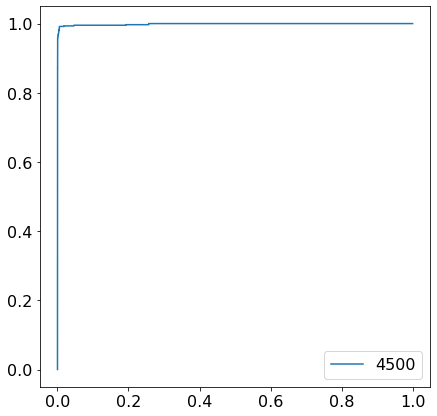

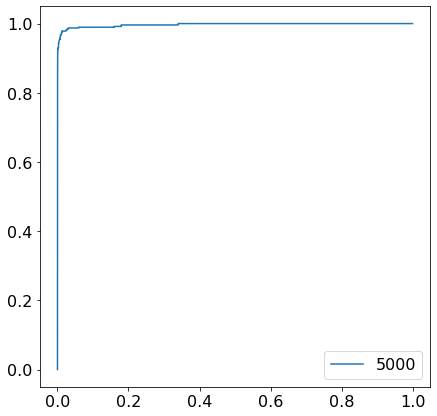

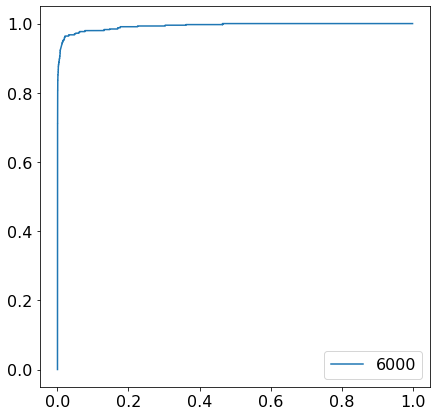

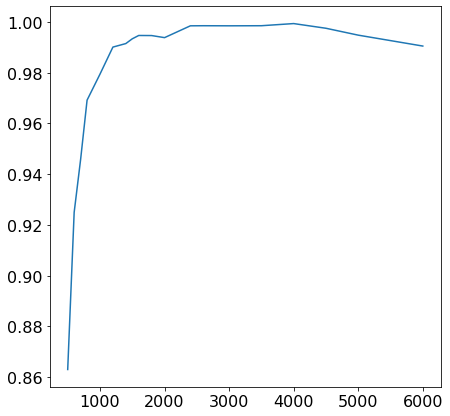

In [41]:
from sklearn import metrics
auc=np.array([])
for i in np.arange(len(masses_list)):
    fpr, tpr, thresholds = metrics.roc_curve(np.append(np.ones(len(PNN_pred_sig_testmass[i])),np.zeros(len(PNN_pred_bkg_testmass[i]))), np.append(PNN_pred_sig_testmass[i],PNN_pred_bkg_testmass[i]),sample_weight=np.append(sig_test_weights_testmass[i],bkg_test_weights_testmass[i]))
    plt.plot(fpr,tpr,label=masses_list[i])
    plt.legend()
    plt.show()
    
    auc=np.append(auc,roc_auc_score(np.append(np.ones(len(PNN_pred_sig_testmass[i])),np.zeros(len(PNN_pred_bkg_testmass[i]))), np.append(PNN_pred_sig_testmass[i],PNN_pred_bkg_testmass[i])))

plt.plot(masses_list,auc)
plt.show()

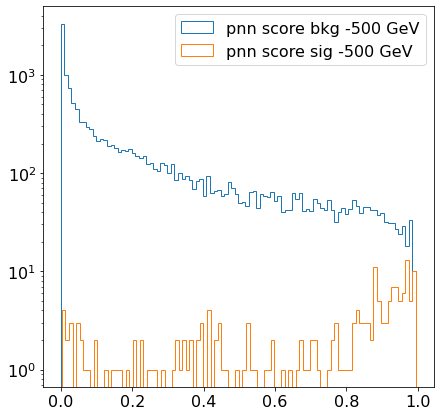

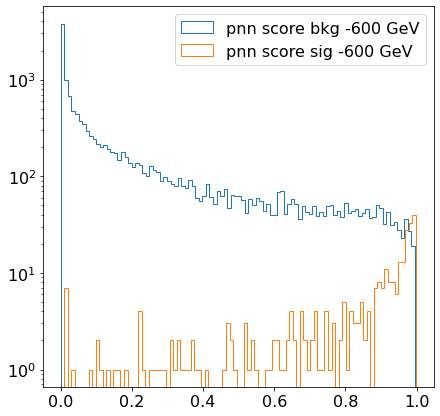

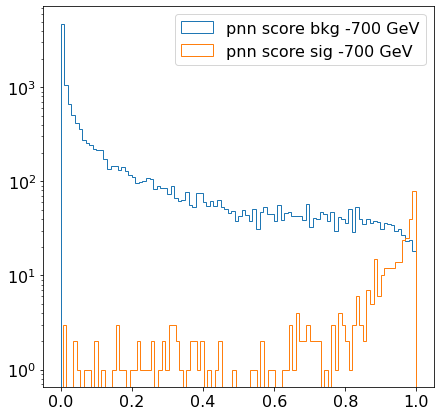

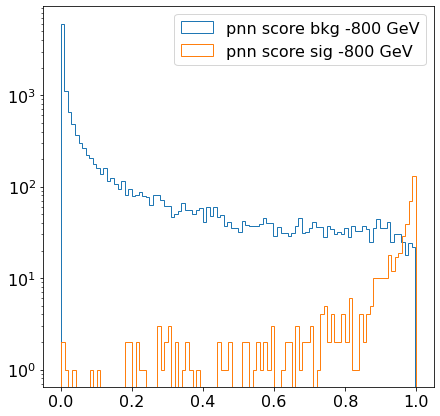

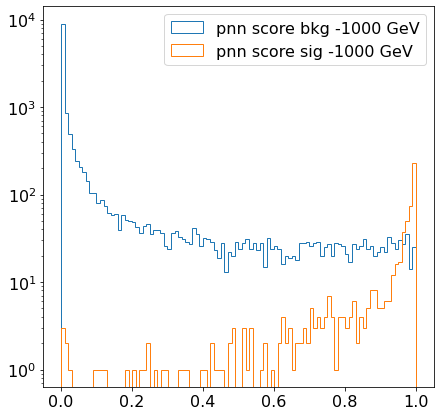

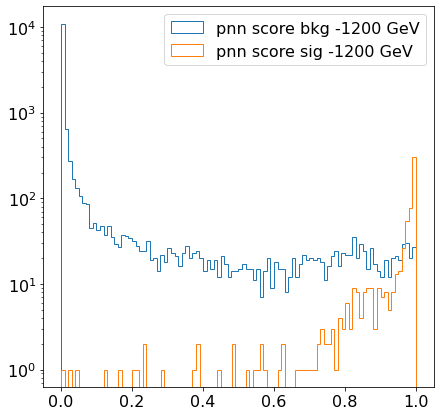

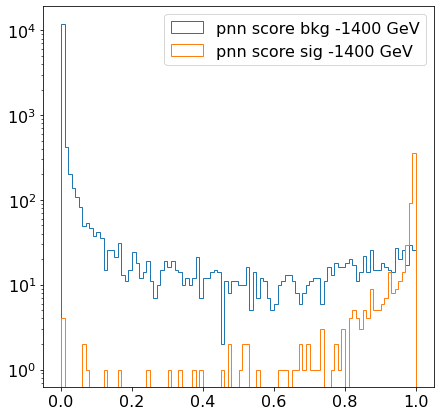

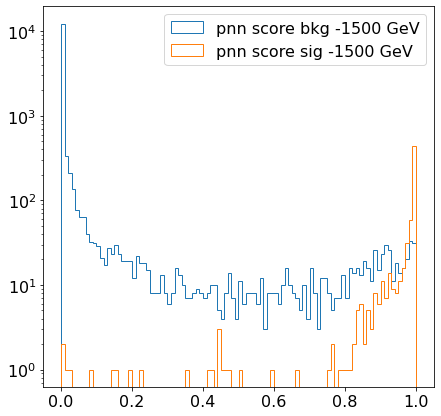

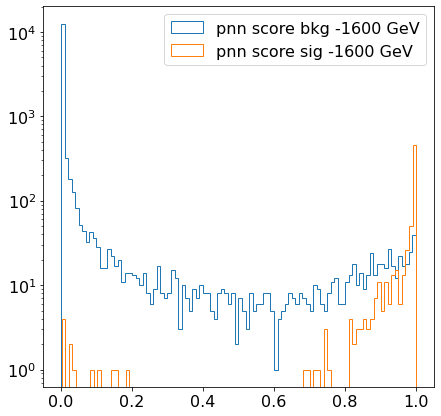

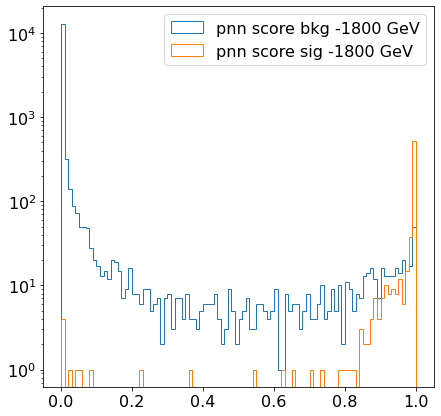

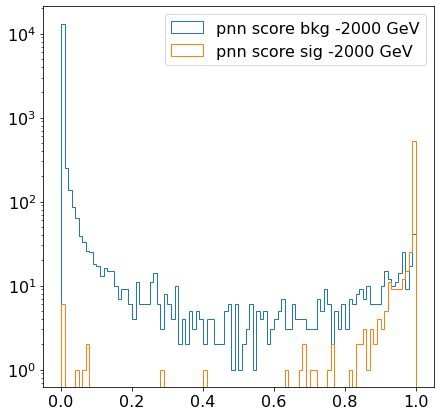

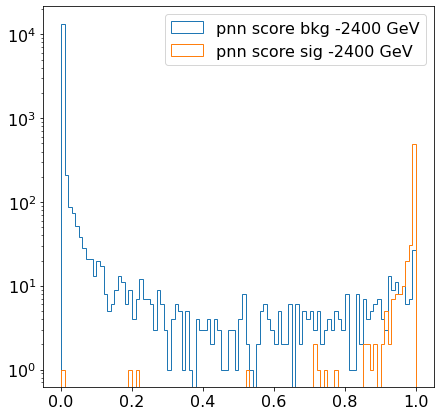

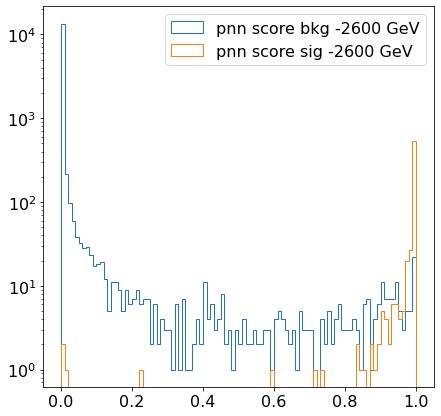

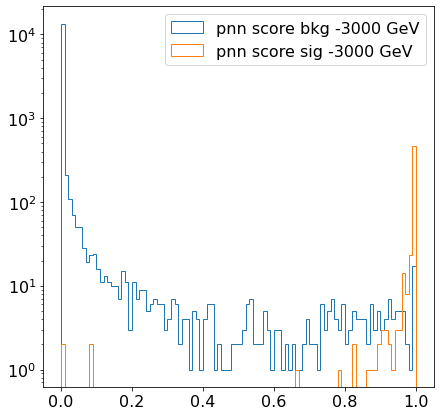

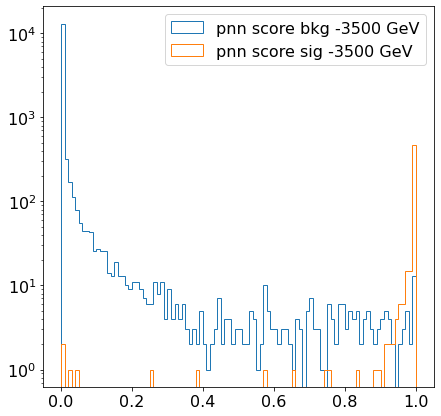

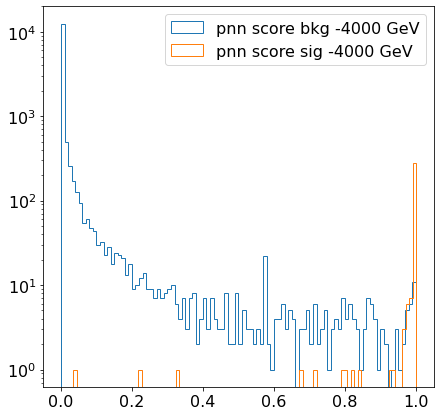

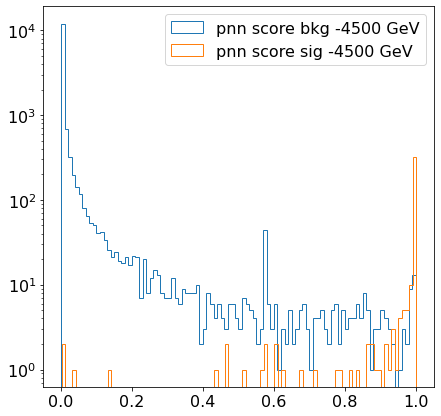

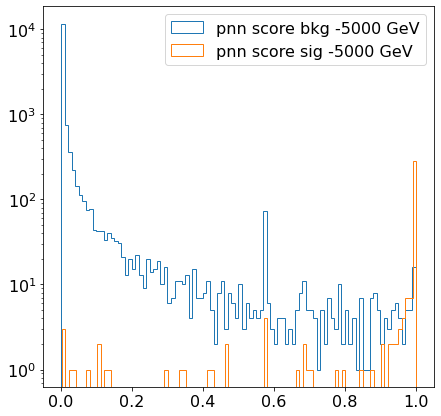

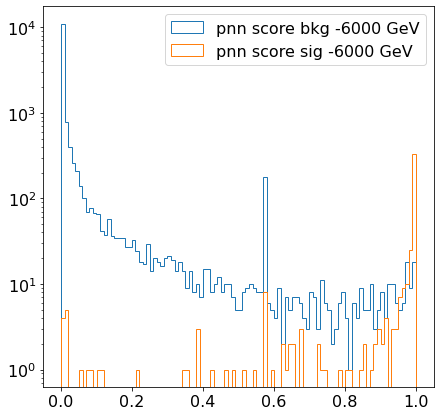

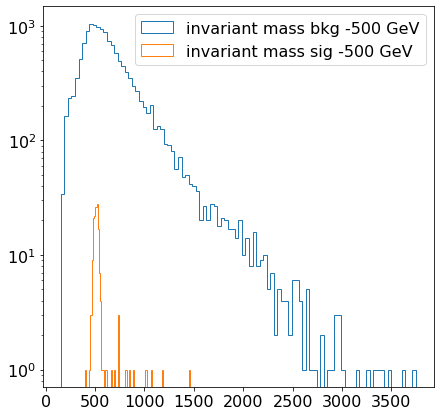

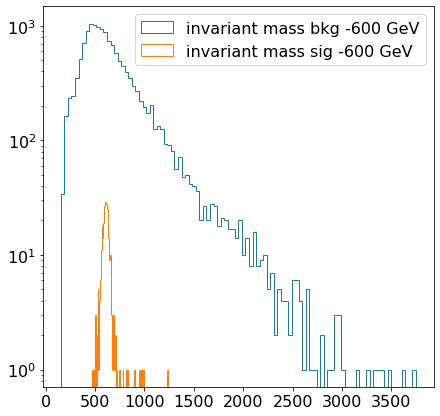

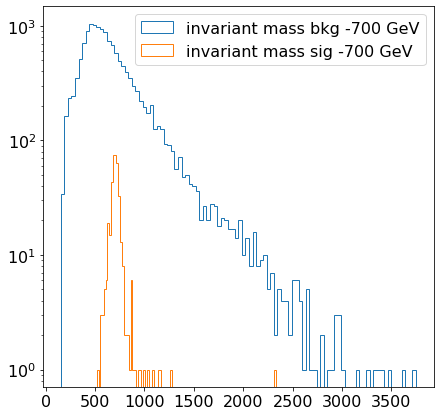

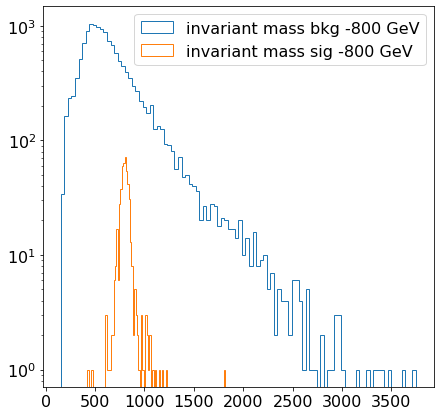

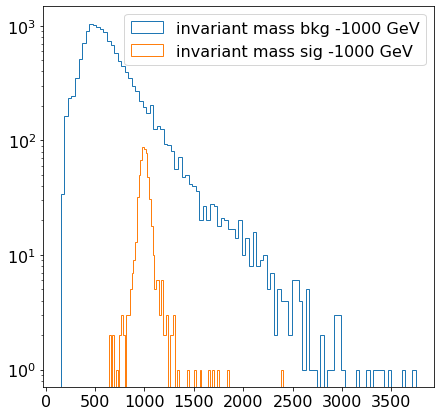

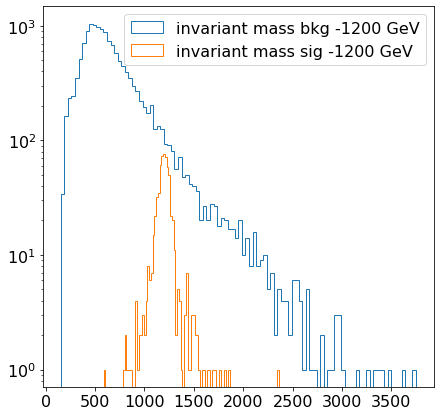

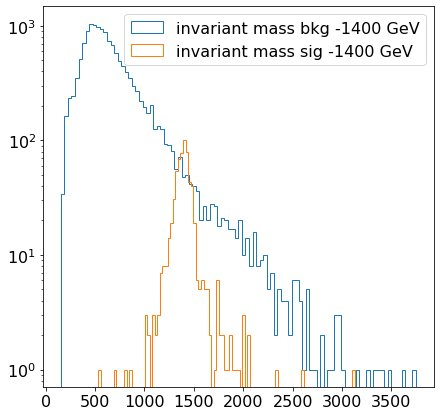

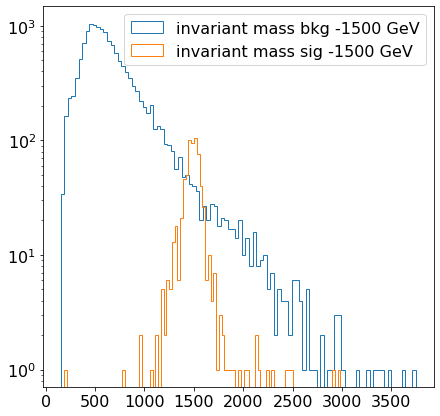

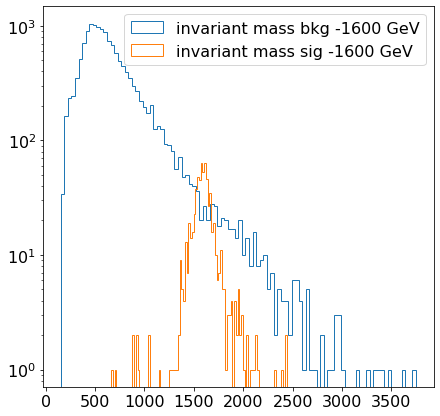

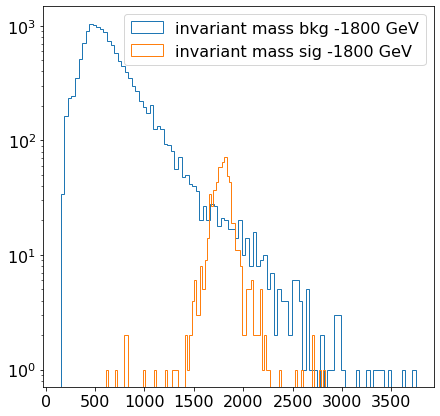

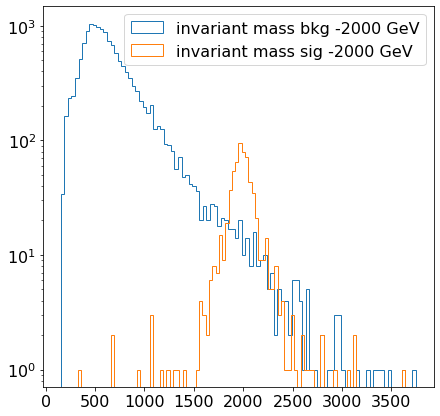

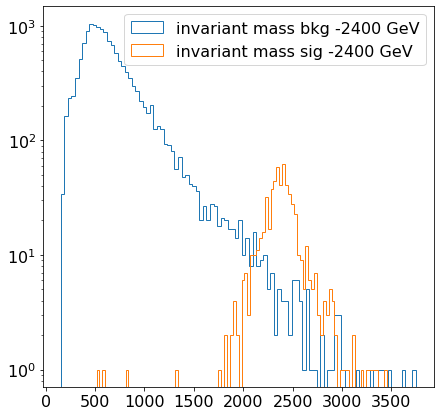

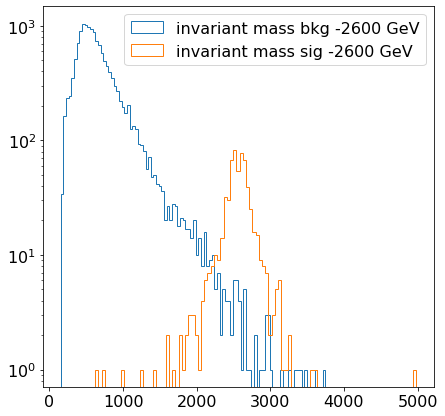

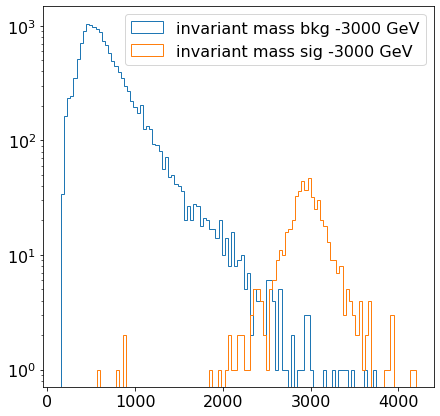

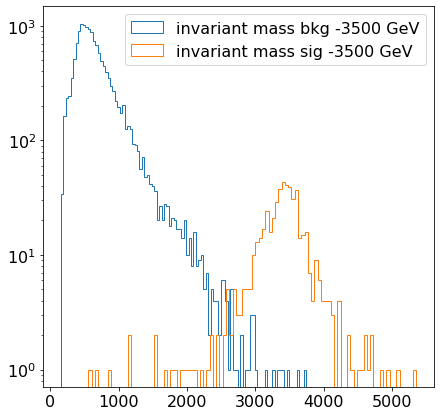

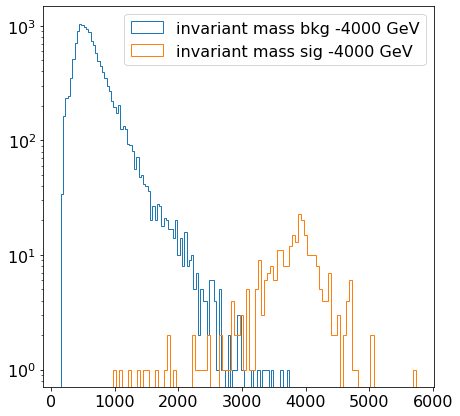

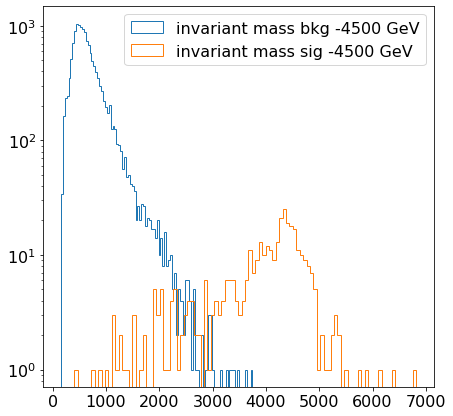

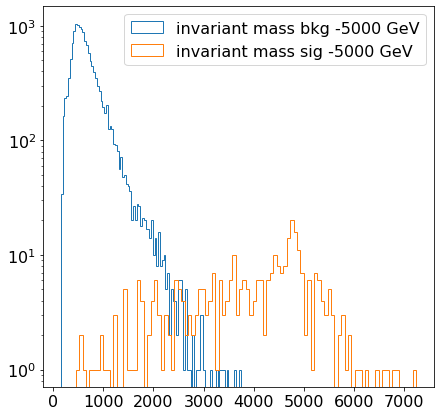

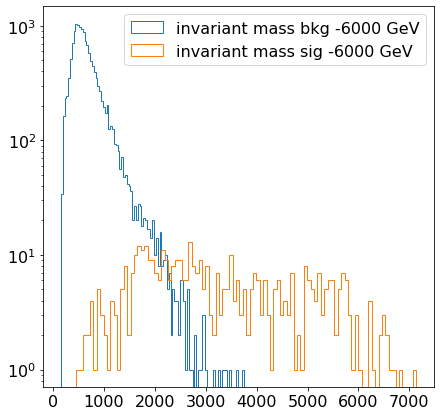

In [42]:
nbins=100
for i in np.arange(len(masses_list)):
    plt.hist(PNN_pred_bkg_testmass[i],bins=nbins,histtype='step',label='pnn score bkg -'+str(masses_list[i])+' GeV')
    plt.hist(PNN_pred_sig_testmass[i],bins=nbins,histtype='step',label='pnn score sig -'+str(masses_list[i])+' GeV')
    plt.yscale('log')
    plt.legend()
    plt.show()

for i in np.arange(len(masses_list)):
    plt.hist(X_boosted_variablem_bkg,bins=nbins,histtype='step',label='invariant mass bkg -'+str(masses_list[i])+' GeV')
    plt.hist(X_boosted_variablem_sig[i],bins=nbins,histtype='step',label='invariant mass sig -'+str(masses_list[i])+' GeV')
    plt.yscale('log')
    plt.legend()
    plt.show()

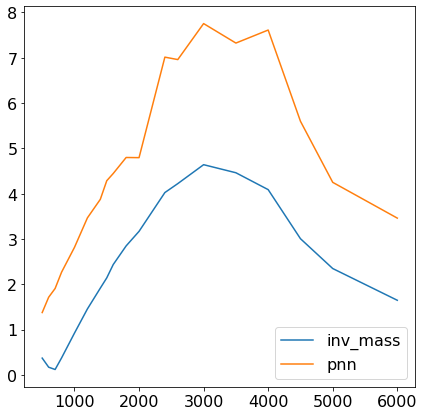

In [134]:
inv_mass_Z0=np.array([])
inv_mass_pnn=np.array([])
for i in np.arange(len(masses_list)):
    inv_mass_Z0=np.append(inv_mass_Z0,np.abs(X_boosted_variablem_bkg.mean()-X_boosted_variablem_sig[i].mean())/np.sqrt(X_boosted_variablem_bkg.std()**2+X_boosted_variablem_sig[i].std()**2))
    inv_mass_pnn=np.append(inv_mass_pnn,np.abs(PNN_pred_bkg_testmass[i].mean()-PNN_pred_sig_testmass[i].mean())/np.sqrt(PNN_pred_bkg_testmass[i].std()**2+PNN_pred_sig_testmass[i].std()**2))

plt.plot(masses_list,inv_mass_Z0,label='inv_mass')
plt.plot(masses_list,inv_mass_pnn,label='pnn')
plt.legend()
plt.show()

mass: 500
pnn
2.733431e-12 0.9952968
max z0: 0.688881930847942


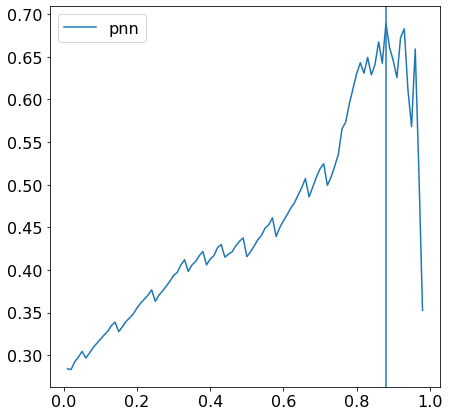

boosted mass
154.48 3711.9262000000012
max z0: 0.3169301366506689


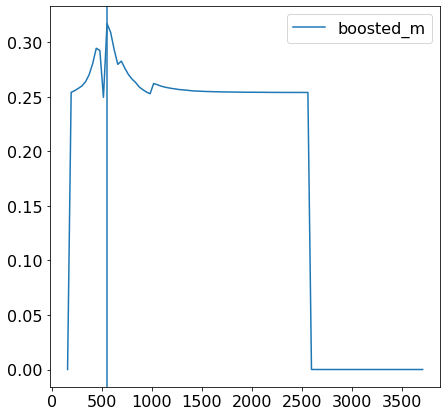

mass: 600
pnn
1.3181856e-12 0.99809533
max z0: 1.3223626410936318


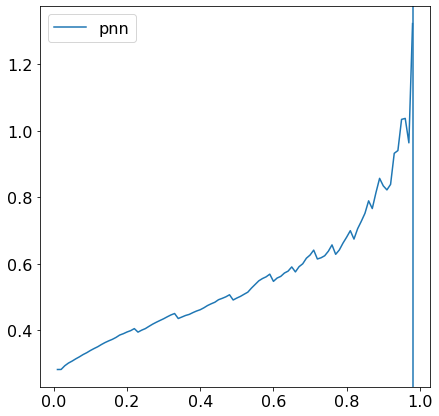

boosted mass
154.48 3711.9262000000012
max z0: 0.31781974806132685


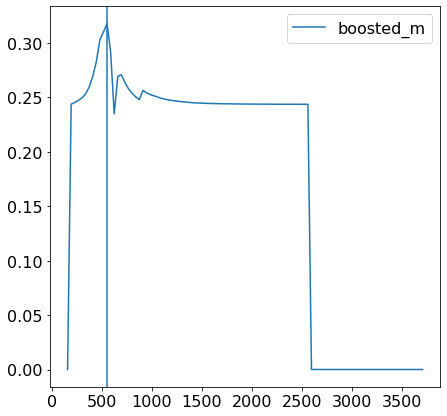

mass: 700
pnn
6.3568573e-13 0.9985322
max z0: 1.3775807367999664


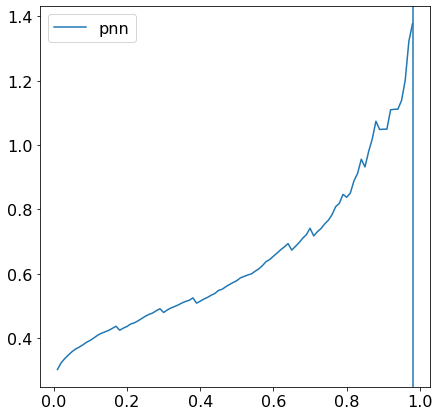

boosted mass
154.48 3711.9262000000012
max z0: 0.4083164124680669


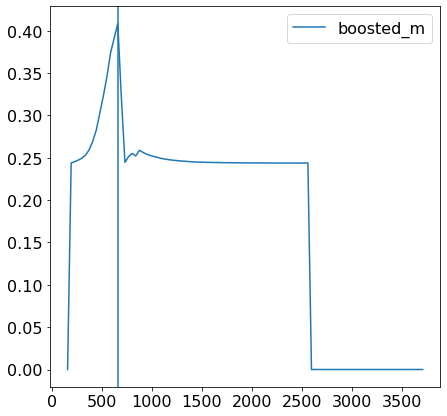

mass: 800
pnn
3.0655673e-13 0.9988211
max z0: 2.504293173710651


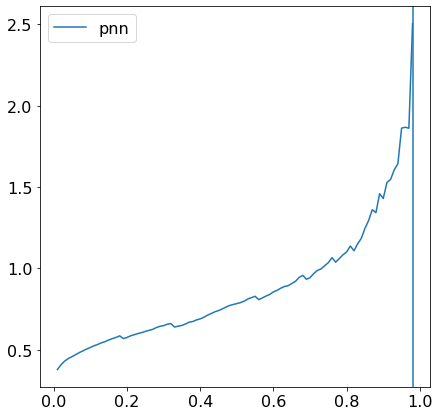

boosted mass
154.48 3711.9262000000012
max z0: 0.546895556863134


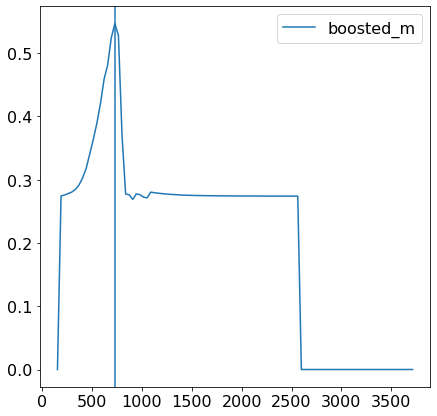

mass: 1000
pnn
7.129285e-14 0.9997458
max z0: 2.995010613052626


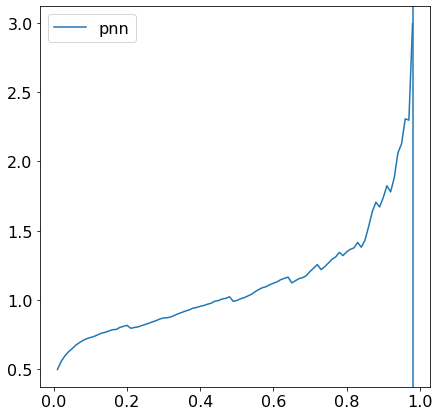

boosted mass
154.48 3711.9262000000012
max z0: 0.8154819900872472


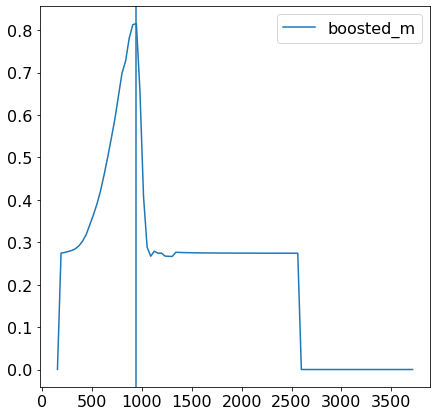

mass: 1200
pnn
1.6579935e-14 0.9999554
max z0: 3.8139766865173557


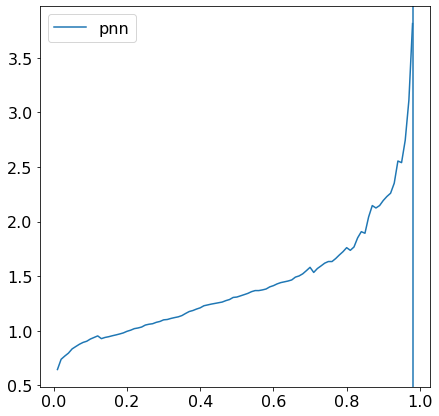

boosted mass
154.48 3711.9262000000012
max z0: 1.1392709852039236


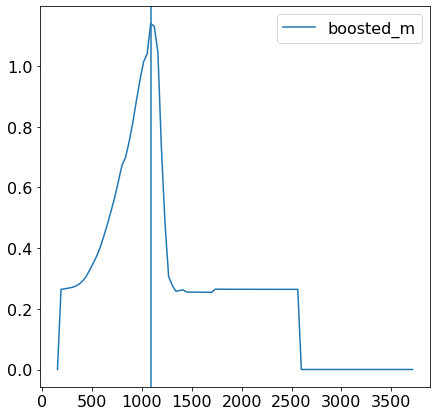

mass: 1400
pnn
3.8558308e-15 0.9999715
max z0: 3.3954086094226335


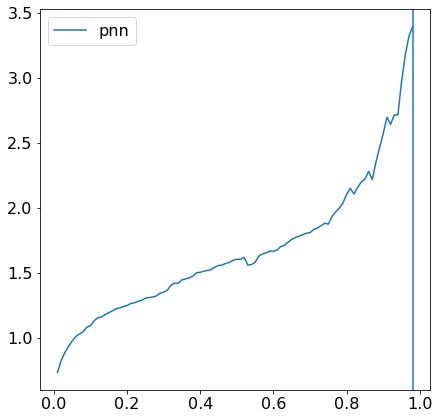

boosted mass
154.48 3711.9262000000012
max z0: 1.5085101645284458


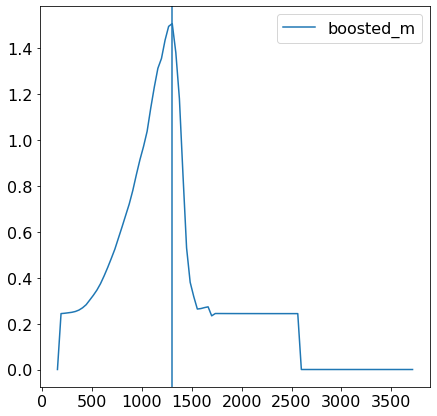

mass: 1500
pnn
1.859458e-15 0.9999877
max z0: 3.6813422943452765


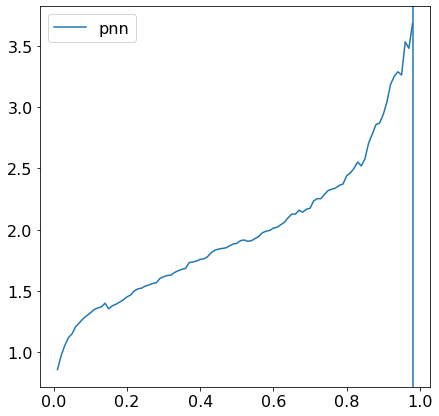

boosted mass
154.48 3711.9262000000012
max z0: 1.9190623202003014


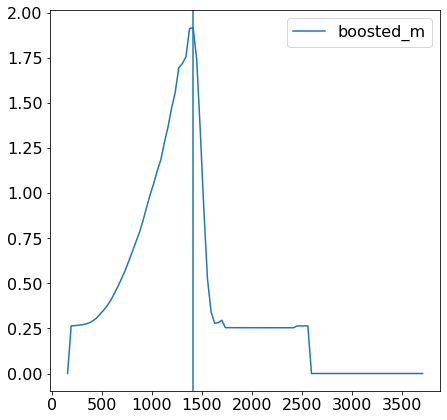

mass: 1600
pnn
8.967157e-16 0.9999907
max z0: 4.200914622521007


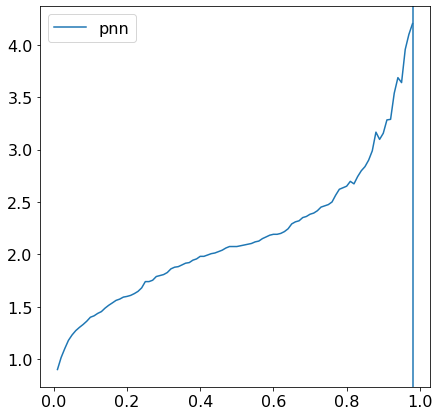

boosted mass
154.48 3711.9262000000012
max z0: 2.2332303364241697


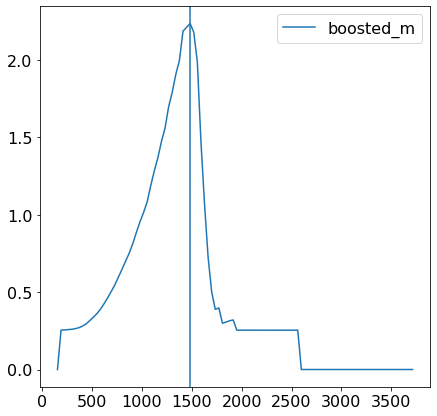

mass: 1800
pnn
2.0854027e-16 0.9999918
max z0: 4.834965215861396


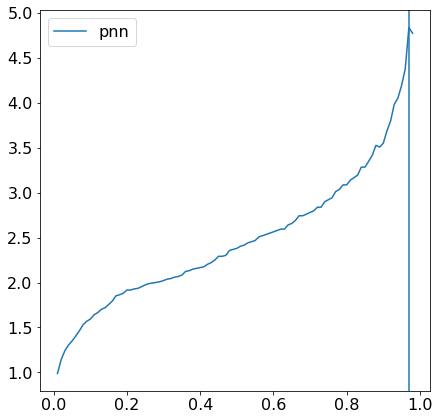

boosted mass
154.48 3711.9262000000012
max z0: 2.9171118060822905


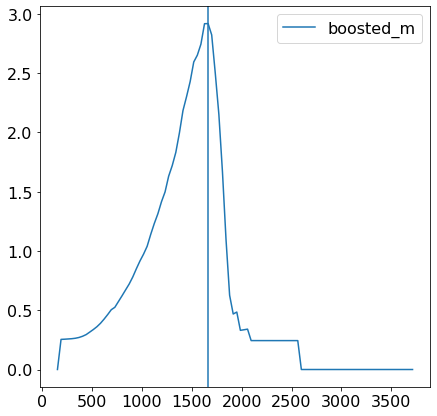

mass: 2000
pnn
4.849814e-17 0.99999976
max z0: 5.969433405470671


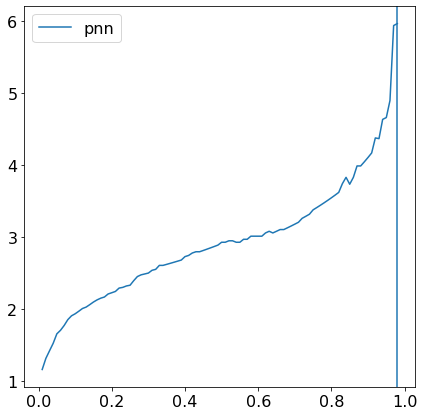

boosted mass
154.48 3711.9262000000012
max z0: 3.7550082279335055


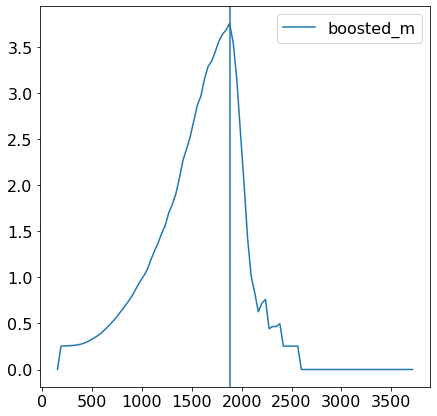

mass: 2400
pnn
3.79441e-18 1.0
max z0: 7.303021692384425


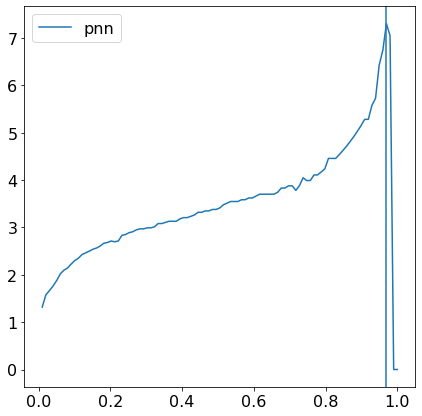

boosted mass
154.48 3711.9262000000012
max z0: 5.73565112652891


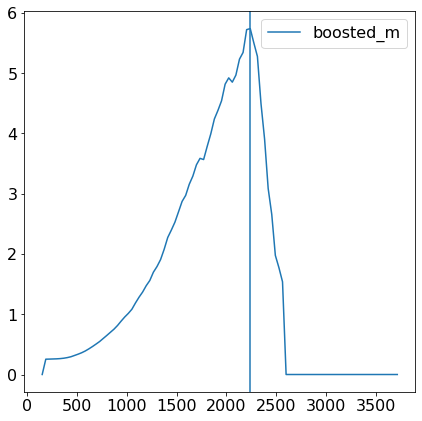

mass: 2600
pnn
7.136427e-18 0.9999999
max z0: 8.14206878621275


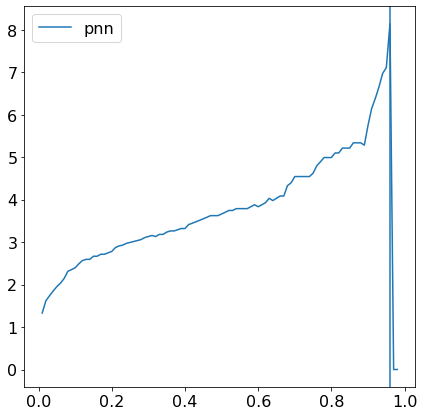

boosted mass
154.48 4929.1609
max z0: 6.612955249467182


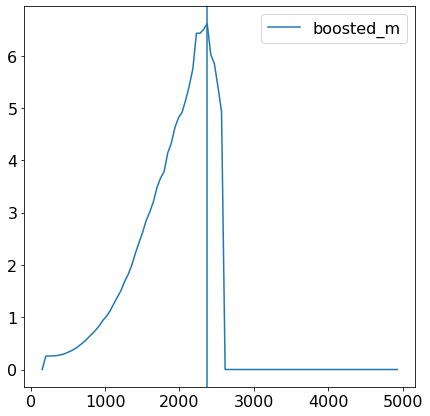

mass: 3000
pnn
2.5243663e-17 1.0
max z0: 8.676152507432727


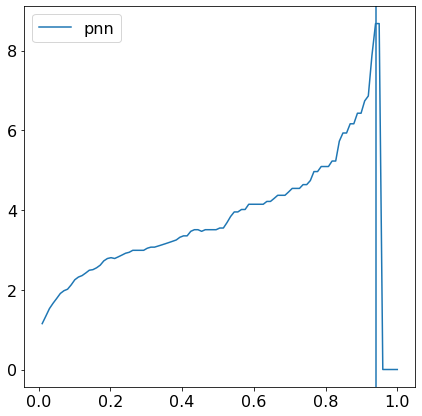

boosted mass
154.48 4159.495300000001
max z0: 7.603525932001949


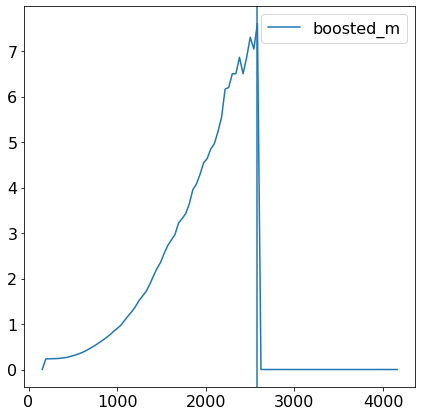

mass: 3500
pnn
8.379339e-18 1.0
max z0: 9.515531837811478


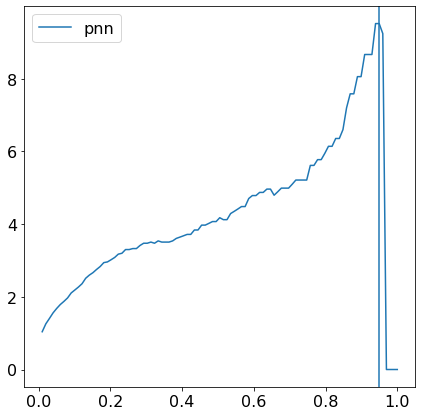

boosted mass
154.48 5297.015200000001
max z0: 8.055934780909155


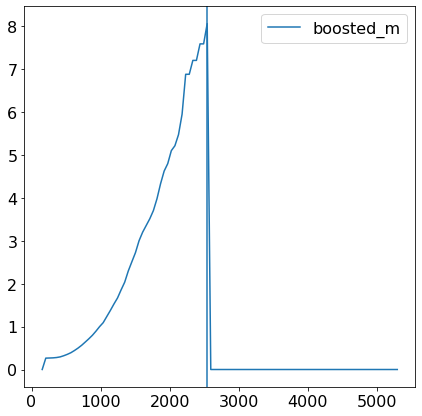

mass: 4000
pnn
1.1441883e-18 1.0
max z0: 8.960275406360005


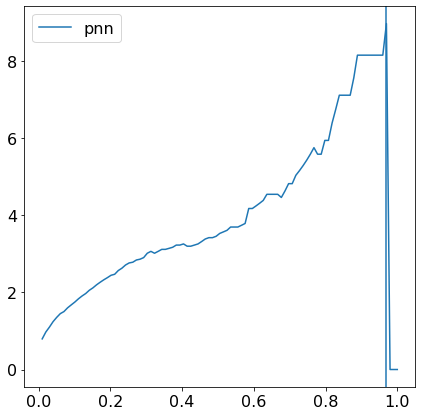

boosted mass
154.48 5679.590799999998
max z0: 8.142068786866437


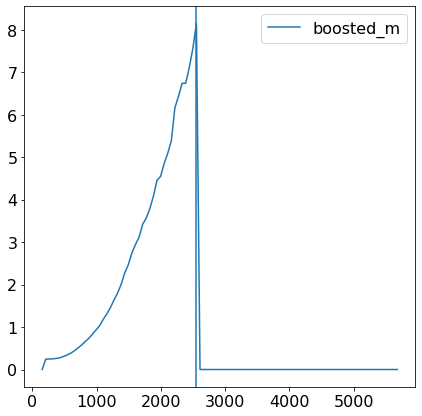

mass: 4500
pnn
5.8466875e-18 1.0
max z0: 8.676170338649476


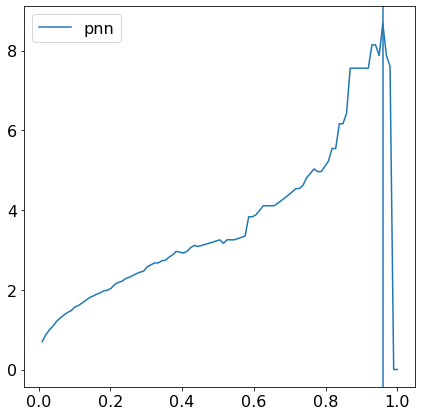

boosted mass
154.48 6747.998799999999
max z0: 7.6035598511463185


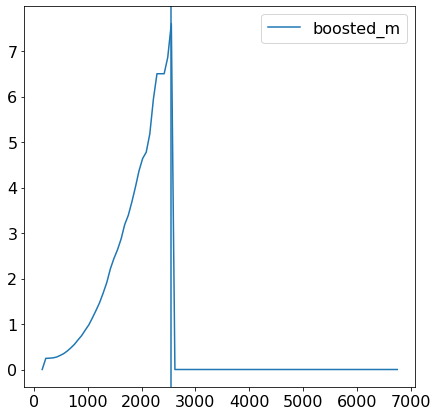

mass: 5000
pnn
6.469549e-17 1.0
max z0: 7.794786014939408


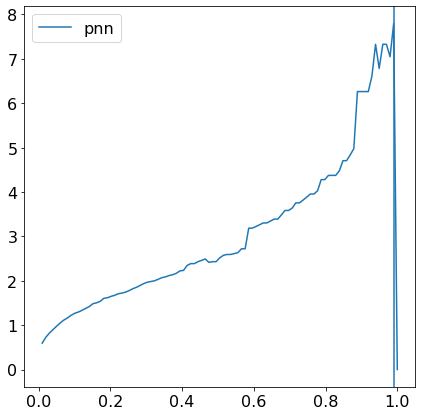

boosted mass
154.48 7162.393000000001
max z0: 7.047542525994518


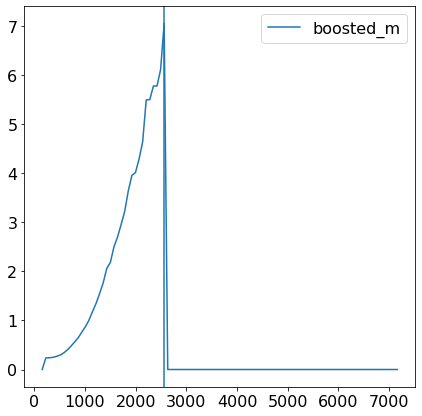

mass: 6000
pnn
3.1050164e-14 1.0
max z0: 7.327970191364448


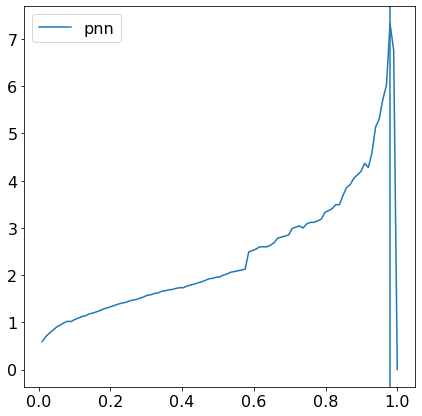

boosted mass
154.48 7060.264600000001
max z0: 5.405535002493377


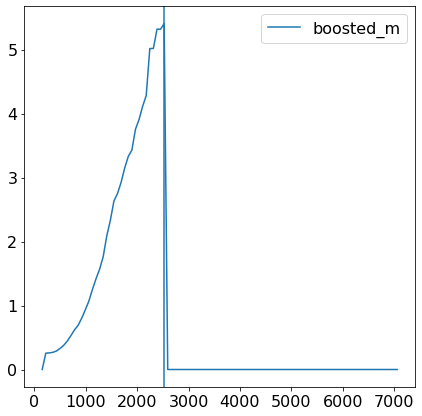

In [43]:
scaling=5e-2

Z_pnn_list=list()
Z_pnn_max_list=list()
Z_boostedm_list=list()
Z_boostedm_max_list=list()

x_pnn_list=list()
x_boostedm_list=list()

for i in np.arange(len(masses_list)):
    print('mass:',masses_list[i])
    
    print('pnn')
    Z0_pnn_max,x0_pnn_max,Z0_pnn,bmin_pnn,x_int_pnn=compute_sigz0(PNN_pred_bkg_testmass[i],bkg_test_weights_testmass[i],PNN_pred_sig_testmass[i],sig_test_weights_testmass[i],scaling,'pnn')
    plt.plot(x_int_pnn,Z0_pnn,label='pnn')
    #plt.plot(x_int_pnn,bmin_pnn,label='pnn_bmin')
    plt.axvline(x=x0_pnn_max)
    #plt.plot(x_int_pnn,b_inf*np.ones(len(x_int_pnn)),label='b_inf')
    #plt.ylim([0,1e1/scaling])
    plt.legend()
    plt.show()
    
    print('boosted mass')
    Z0_boosted_max,x0_boosted_m_max,Z0_boosted_m,bmin_m,x_int_m=compute_sigz0(X_boosted_m_bkg,X_boosted_variablem_bkg_weights,X_boosted_variablem_sig[i],X_boosted_variablem_sig_weights[i],scaling,'boosted_m')
    plt.plot(x_int_m,Z0_boosted_m,label='boosted_m')
    #plt.plot(x_int_m,bmin_m,label='boosted_m_bmin')
    plt.axvline(x=x0_boosted_m_max)
    #plt.ylim([0,1e1/scaling])
    plt.legend()
    plt.show()

    Z_pnn_max_list.append(Z0_pnn_max)
    Z_boostedm_max_list.append(Z0_boosted_max)
    Z_pnn_list.append(Z0_pnn)
    Z_boostedm_list.append(Z0_boosted_m)
    x_pnn_list.append(x0_pnn_max)
    x_boostedm_list.append(x0_boosted_m_max)
    

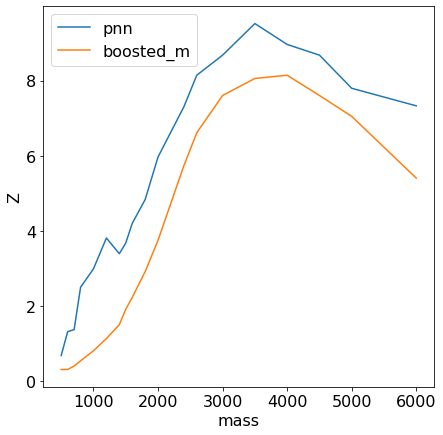

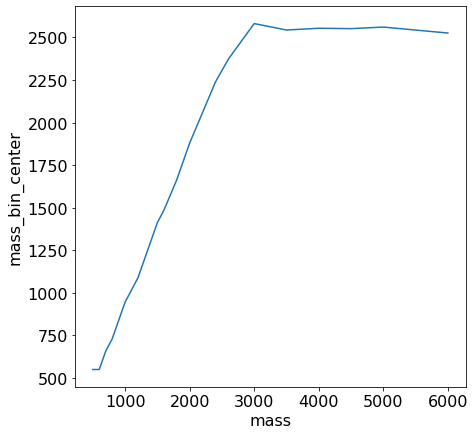

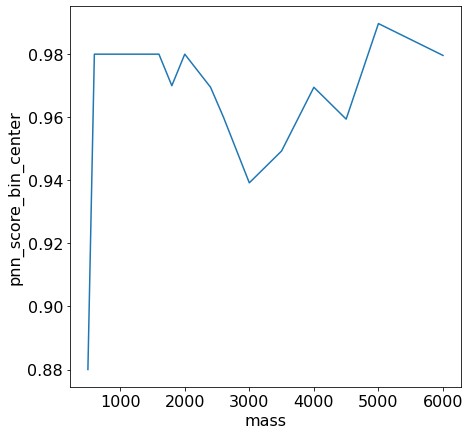

In [44]:
#v2
#merged VBF Radion
plt.plot(masses_list,Z_pnn_max_list,label='pnn')
plt.plot(masses_list,Z_boostedm_max_list,label='boosted_m')
#plt.yscale('log')
plt.ylabel('Z')
plt.xlabel('mass')
plt.legend()
plt.show()

plt.plot(masses_list,x_boostedm_list)
plt.ylabel('mass_bin_center')
plt.xlabel('mass')
plt.show()

plt.plot(masses_list,x_pnn_list)
plt.ylabel('pnn_score_bin_center')
plt.xlabel('mass')
plt.show()

In [45]:
from sklearn.decomposition import PCA

In [62]:
pca = PCA(n_components=X_train.shape[0])

In [ ]:
np.corrcoef(X_train[:100,:])

In [63]:
pca.fit(X_train.T)
pca.explained_variance_ratio_

ValueError: n_components=96671 must be between 0 and min(n_samples, n_features)=14 with svd_solver='full'

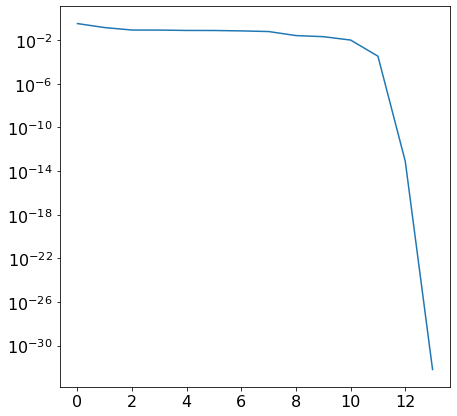

In [58]:
plt.plot(np.arange(14),pca.explained_variance_ratio_)
plt.yscale('log')
plt.show()